# 0. Instructions and setup

## 0.1. Instructions. Part 2: Data Scientist Challenge (3.5 points)

- **Objective:** Explore different techniques to enhance model performance with limited  labeled data. You will be limited to 32 labeled examples in your task.  The rest can be viewed as unlabelled data. 

- **Tasks:**
  - **a. BERT Model with Limited Data (0.5 points):** Train a BERT-based model using only 32 labeled examples and assess its performance.
  - **b. Dataset Augmentation (1 point):** Experiment with an automated technique to increase your dataset size **without using LLMs** (chatGPT / Mistral / Gemini / etc...). Evaluate the impact on model performance.
  - **c. Zero-Shot Learning with LLM (0.5 points):** Apply a LLM (chatGPT/Claude/Mistral/Gemini/...) in a zero-shot learning setup. Document the performance.
  - **d. Data Generation with LLM (1 point):** Use a LLM (chatGPT/Claude/Mistral/Gemini/...) to generate new, labeled  dataset points. Train your BERT model with it + the 32 labels. Analyze  how this impacts model metrics.
  - **e. Optimal Technique Application (0.5 points):** Based on the previous experiments, apply the most effective  technique(s) to further improve your model's performance. Comment your results and propose improvements.

## 0.2. Libraries

In [3]:
# # !pip install polars  # Install polars for faster data processing

In [2]:
# Utilities
import os
import time
import json

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import setfit

# Deep Learning and NLP
import torch
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
from datasets import Dataset
from dotenv import find_dotenv, load_dotenv
from groq import Groq
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import CamembertTokenizer, CamembertForSequenceClassification

from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EarlyStoppingCallback,
    Trainer,
    TrainingArguments,
)

from library.fine_tuning import evaluate_best_finetuned_model
from library.llms import classify_case
from library.metrics import Metrics, evaluate_classification
from library.setfit import evaluate_setfit_on_test, run_setfit_training
from library.utilities import sample_balanced_dataset, set_seed

In [3]:
# Load environment and classes
load_dotenv(find_dotenv())

metrics = Metrics()

In [4]:
# Check the availability of a GPU
print(torch.cuda.is_available())

True


In [104]:
!nvidia-smi

Sun Jun 15 16:55:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.52                 Driver Version: 576.52         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P5              9W /   80W |     403MiB /   8188MiB |     58%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 0.3. Random Seed

In [95]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


## 0.4. Loading the data: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

In [5]:
# Load the cleaned Parquet file
df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_combined.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\matia\AppData\Local\Temp\ipykernel_21596\1903425062.py:2: SyntaxWarning: invalid escape sequence '\F'
  df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_combined.parquet')



Loaded DataFrame shape: (31094, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'labels': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [6]:
# Split the DataFrame into training, validation and test sets
train_df = df.filter(pl.col('split') == 'train')
val_df = df.filter(pl.col('split') == 'validation')
test_df = df.filter(pl.col('split') == 'test')

# Delete the original data to free up memory
del df

# 1. BERT Model with Limited Data

Outline of the intermediate tasks:

1. Preprocessing Pipeline
   - Lowercasing, punctuation stripping (or not, depending on BERT tokenizer).
   - Sentencepiece/BPE tokenization via the CamemBERT (for French) or UmBERTo (for Italian).
   - (Optional) language tags if you merge FR+IT in one model.
2. Hold-out Split. Since you only have 32 labels: use stratified k-fold CV (e.g. 8 × 4-fold) to get reliable estimates, or leave-one-out if you want maximum training data per fold.
3. BERT Model with Only 32 Examples
   - Model Choice: Pick a multilingual BERT (mBERT) or separate CamemBERT/UmBERTo checkpoint. Alternatives:
     - Multilingual/monolingual models:
       - One multilingual [`Sentence-Transformer` model](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), such as `paraphrase-multilingual-mpnet-base-v2` (best multilingual performer), `paraphrase-multilingual-MiniLM-L12-v2` (similar performer as the former, but much faster and smaller) or `distiluse-base-multilingual-cased-v1` (worst of the bunch).
       -  [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). [Uncased model](https://huggingface.co/google-bert/bert-base-multilingual-uncased) also available. For an even smaller model, the distilled version can be used: [`distilbert-base-multilingual-cased`](https://huggingface.co/distilbert/distilbert-base-multilingual-cased).
       -  [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve over the performance of the original [CamemBERT](https://huggingface.co/almanach/camembert-base) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
       -  [FlauBERT](https://huggingface.co/docs/transformers/en/model_doc/flaubert), another model pre-trained on French text. Paper: "[FlauBERT: Unsupervised Language Model Pre-training for French](https://arxiv.org/abs/1912.05372)". 
       -  [BERT Base Italian Cased](https://huggingface.co/dbmdz/bert-base-italian-cased), [Uncased](https://huggingface.co/dbmdz/bert-base-italian-uncased), ,and [XXL Uncased](https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased). 
       -  [UmBERTo Commoncrawl Cased](https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1), another model trained with a large corpus of texts in Italian.
      -  Domain-specific models (law):
          - [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased) does not seem to be a good option as it was trained only on English data.
          - [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).
          - [ITALIAN-LEGAL-BERT](https://huggingface.co/dlicari/Italian-Legal-BERT) for legal text in Italian. Paper explaining the model: [ITALIAN-LEGAL-BERT models for improving natural language processing tasks in the Italian legal domain](https://www.sciencedirect.com/science/article/pii/S0267364923001188).
     - Models to try: 
       - For both languages: `paraphrase-multilingual-MiniLM-L12-v2` (of the SentenceTransformers, good balance between performance and speed), BERT multilingual base model (cased).
       - For French: CamemBERT, FlauBERT, CamemBERTav2 (based on DebertaV2 architecture), JuriBERT.
       - For Italian: BERT Base Italian Cased, UmBERTo Commoncrawl Cased, ITALIAN-LEGAL-BERT.
     - [Model memory estimator](https://huggingface.co/docs/accelerate/en/usage_guides/model_size_estimator): in order to know whether a model actually fits in the memory of your computer.
   - Fine-tuning Setup.
     - Freeze or unfreeze last n encoder layers—try both.
     - Small learning rate (2e-5 – 5e-5), batch size = 8 or 16.
     - Early stopping on validation loss.
4. Training & Evaluation
    - Run your k-fold CV training loops.
    - Track accuracy, F1, precision, recall per fold.
    - Report mean ± std.
5. Error Analysis and feature interpretation.
    - Use `LIME` for analyzing the most relevant features for classifying the texts. 
    - Look at which examples are mispredicted.
    - Check language breakdown (FR vs. IT) to see if one is harder.

## 1.1. Using SetFit ("Sentence Transformer Fine-Tuning")

Notebook of reference: `Session_6_2_Zero_Shot_Classification.ipynb`, introduction, step 1 (loading data) and step 6 ("Few-Shot Classification with SetFit").

Applying SetFit (the “Sentence Transformer Fine-Tuning” recipe) can be regarded as **training** (it fine-tunes a pre-trained sentence-embedding model, plus fits a small classifier on top). Furthermore, SetFit was built **for** getting strong performance with as few as a few dozen labeled examples.

---

**Why SetFit can be regarded as training**

- **Contrastive fine-tuning:**
  We start with a frozen (or lightly unfrozen) Sentence-Transformer model and then *fine-tune* it on automatically generated sentence pairs derived from your 32 labels.
- **Classifier head training:**
  After contrastive tuning, SetFit fits a lightweight logistic-regression (or small MLP) classifier on the resulting embeddings.
- Both steps update model parameters—so it’s training/fine-tuning, not mere prompt-engineering or zero-shot.

---

**Why SetFit excels in limited-label regimes**

1. **Data amplification via contrastive pairs**

   - From each labeled example, SetFit creates positive pairs (e.g. two different augmentations of the same sentence) and negative pairs (across classes), turning 32 labels into hundreds or thousands of pairwise signals.
   - That extra signal helps the embedding space separate classes, even when you only have a few “gold” labels.

1. **Lightweight classifier**

   * Because the embedding model has already been tuned to distinguish the classes, the final classifier can be a simple logistic or MLP—so it needs very few examples to learn decision boundaries.

2. **Empirical few-shot strength**

   * In benchmarks, SetFit often outperforms standard BERT fine-tuning with few labels, and it’s much faster to train (no full back-prop through all BERT layers).

---

Note that there are 2 aspects that we need to implement for SetFit to work properly:

1. **Balance the examples of positive and negative classes** that will be passed for contrastive learning. Since approximately 29% of the labels are positive (approved motions) and the other 71% correspond to rejected motions, passing examples for contrastive learning without balancing the clases would bias the embedding space towards the majority class.
   
2. We need to **run several iterations** in order to get lower variability in the results, as a single training run can be highly variable due to randomness in the example sampling (as we only pass 32 labelled examples). Therefore, if we don't run several iterations for SetFit, the results would be highly noisy. Averaging across iterations smooths out this variance and gives us the true expected performance.

Note that SetFit only natively supports sentence-transformer models: passing one which is [not](https://huggingface.co/models?library=sentence-transformers&author=sentence-transformers) (see also the [docs](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)) will make SetFit automatically wrap the BERT model with a sentence-transformers layer using mean pooling. Using a model that is not part of the `sentence-transformers` will yield the following message:

> No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with mean pooling.

However, for better performance with SetFit, it is preferred to use a model that was specifically pre-trained as a sentence transformer.

   - Model Choice: Pick a multilingual BERT (mBERT) or separate CamemBERT/UmBERTo checkpoint. Alternatives:
     - Multilingual/monolingual models:
       - One multilingual [`Sentence-Transformer` model](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), such as `paraphrase-multilingual-mpnet-base-v2` (best multilingual performer), `paraphrase-multilingual-MiniLM-L12-v2` (similar performer as the former, but much faster and smaller) or `distiluse-base-multilingual-cased-v1` (worst of the bunch).
       -  [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). [Uncased model](https://huggingface.co/google-bert/bert-base-multilingual-uncased) also available. Paper: "[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)". 
       -  [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve over the performance of the original [CamemBERT](https://huggingface.co/docs/transformers/en/model_doc/camembert) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
       -  [FlauBERT](https://huggingface.co/docs/transformers/en/model_doc/flaubert), another model pre-trained on French text. Paper: "[FlauBERT: Unsupervised Language Model Pre-training for French](https://arxiv.org/abs/1912.05372)". 
       -  [BERT Base Italian Cased](https://huggingface.co/dbmdz/bert-base-italian-cased), [Uncased](https://huggingface.co/dbmdz/bert-base-italian-uncased), ,and [XXL Uncased](https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased). 
       -  [UmBERTo Commoncrawl Cased](https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1), another model trained with a large corpus of texts in Italian.
      -  Domain-specific models (law):
          - [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased) does not seem to be a good option as it was trained only on English data.
          - [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).
          - [ITALIAN-LEGAL-BERT](https://huggingface.co/dlicari/Italian-Legal-BERT) for legal text in Italian. Paper explaining the model: [ITALIAN-LEGAL-BERT models for improving natural language processing tasks in the Italian legal domain](https://www.sciencedirect.com/science/article/pii/S0267364923001188).

Models to try: 
- For both languages: `paraphrase-multilingual-MiniLM-L12-v2` (of the SentenceTransformers, good balance between performance and speed), distilled BERT multilingual base model (cased) ([`distilbert-base-multilingual-cased`](https://huggingface.co/distilbert/distilbert-base-multilingual-cased).)
- For French: CamemBERTav2 (based on DebertaV2 architecture), JuriBERT.
- For Italian: BERT Base Italian Cased, ITALIAN-LEGAL-BERT.

[Model memory estimator](https://huggingface.co/docs/accelerate/en/usage_guides/model_size_estimator): in order to know whether a model actually fits in the memory of your computer:



Finally, consider that there might be some memory issues by running SetFit:  ( https://github.com/huggingface/setfit/issues/472 ). Adapt the hyperparameters consequently to your memory limitations.

### Multilingual models

#### `paraphrase-multilingual-MiniLM-L12-v2`

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()
train_df_setfit = train_df_setfit.rename({'labels': 'label'})
val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 10  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # Path to the pre-trained model
batch_size = 64 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m1 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)


Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.242800


Training completed.
Validation F1: 0.2857
New best model found with f1: 0.2857

Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.287600


Training completed.
Validation F1: 0.2508

Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.293600


Training completed.
Validation F1: 0.2566

Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.305100


Training completed.
Validation F1: 0.2593

Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.256500


Training completed.
Validation F1: 0.3069
New best model found with f1: 0.3069

Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.269200


Training completed.
Validation F1: 0.2338

Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2830

Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.282000


Training completed.
Validation F1: 0.2618

Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2837

Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259700


Training completed.
Validation F1: 0.2279
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/a/setfit_best_paraphrase-multilingual-MiniLM-L12-v2
Results saved to: results/part_2/a/setfit_results_paraphrase-multilingual-MiniLM-L12-v2.parquet


In [ ]:
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'

results_m1 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m1)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m1.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: paraphrase-multilingual-MiniLM-L12-v2


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.55,0.285714,0.204545,0.473684,1
0.546,0.250825,0.182692,0.4,2
0.49,0.25656,0.177419,0.463158,3
0.52,0.259259,0.183406,0.442105,4
0.458,0.306905,0.202703,0.631579,5
0.502,0.233846,0.165217,0.4,6
0.544,0.283019,0.201794,0.473684,7
0.436,0.26178,0.174216,0.526316,8
0.384,0.283721,0.18209,0.642105,9



Mean metrics across all iterations:
{'accuracy': [0.5010000000000001], 'f1': [0.26495709982755045], 'precision': [0.1849223869644958], 'recall': [0.47789473684210526]}


#### BERT-base multilingual cased

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()
train_df_setfit = train_df_setfit.rename({'labels': 'label'})
val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "google-bert/bert-base-multilingual-cased"  # Path to the pre-trained model
batch_size = 8 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m2 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [ ]:
model_name = 'bert-base-multilingual-cased'

results_m2 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m2)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m2.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: google-bert/bert-base-multilingual-cased


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.532,0.26875,0.191111,0.452632,1
0.42,0.299517,0.194357,0.652632,2
0.61,0.229249,0.183544,0.305263,3
0.464,0.298429,0.198606,0.6,4
0.496,0.296089,0.201521,0.557895,5


Considering that the performance with these multilingual models is worse than random, we will focus on improving performance for the texts (only) in French. Since the number of observations for the cases in Italian is low, we will not try to improve performance for that subset. 

### Models pre-trained in French

#### CamemBERT

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_fr_df = train_df.clone()
val_fr_df = val_df.clone()
# Keep only the columns where the language is French
train_fr_df = train_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})
val_fr_df = val_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_fr_df = val_fr_df.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m3 = run_setfit_training(
    train_df=train_fr_df, 
    val_df=val_fr_df, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [ ]:
model_name = 'camembert-base'

results_m3 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m3)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m3.filter(pl.col('f1') == results_m3['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.642,0.286853,0.25,0.336449,1
0.644,0.245763,0.224806,0.271028,2
0.446,0.31941,0.216667,0.607477,3
0.46,0.341463,0.231023,0.654206,4
0.628,0.243902,0.215827,0.280374,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.46,0.341463,0.231023,0.654206,4


#### JuriBERT-base

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_fr_df = train_df.clone()
val_fr_df = val_df.clone()
# Keep only the columns where the language is French
train_fr_df = train_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})
val_fr_df = val_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "dascim/juribert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_fr_df = val_fr_df.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m4 = run_setfit_training(
    train_df=train_fr_df, 
    val_df=val_fr_df, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [ ]:
model_name = 'juribert-base'

results_m4 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m4)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m4.filter(pl.col('f1') == results_m4['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: juribert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1
0.418,0.285012,0.193333,0.542056,2
0.522,0.307246,0.222689,0.495327,3
0.578,0.259649,0.207865,0.345794,4
0.574,0.292359,0.226804,0.411215,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1


## 1.2. Standard fine-tuning

Notebook of reference: `Session_5_1_BERT_HF_Implementation.ipynb`, sections 1, 2 and 5.

### With CamemBERT

First, we set basic parameters that we will need for fine-tuning a model based on the BERT architecture.

In [ ]:
model_name = "almanach/camembert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Model: almanach/camembert-base, Max Length: 512


Second, we tokenize the text and create the vocabulary IDs in order to create the inputs for the BERT-based model.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
sample_text = train_df.select('text')['text'][0]  # Select the text of the first sample

# Tokenize the sample text considering the maximum length
tokens = tokenizer(
    sample_text, 
    max_length=max_length,  # Truncate to the maximum length of the model 
    truncation=True, 
    padding='max_length'  # Pad to the maximum length
)

# Display input IDs (tokenized & padded)
print(f"Sample text: {sample_text}")
print("Token IDs:", tokens["input_ids"])
print("Length:", len(tokens["input_ids"]))
print("Attention Mask:", tokens["attention_mask"])

Sample text: Faits: A. Le 28 octobre 2002 à 14 h.50, A._, domiciliée en France, circulait, au volant d'une voiture dont elle est détentrice, sur la route d'Hermance (GE) en direction de Corsier, après avoir quitté une place de stationnement. Alors qu'elle obliquait à gauche pour entrer dans le parking de la poste de Collonge-Bellerive en vue d'effectuer un demi-tour, l'arrière gauche de sa voiture a été heurté par un scooter de marque Honda Fes piloté par son détenteur, B._. Ce dernier a été grièvement blessé. Au lieu de l'accident, la vitesse maximale autorisée était de 50 km/h. A l'endroit où l'automobiliste a obliqué à gauche - manoeuvre qui était permise -, la ligne centrale est pointillée, alors qu'elle est pleine avant et après cet endroit. Le scooter a laissé une trace de freinage de 9,7 mètres qui commence sur la ligne de sécurité et évolue vers la gauche. La conductrice de la voiture a reconnu qu'elle n'avait pas regardé derrière elle avant d'obliquer. La police a infligé une 

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))
val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    5,  9447,    10,    43,  9447,    10,    43,   114,     9,   502,
          124,   108,   732,  7416,    36,   181,   667,  9474,   275,     9,
          862,    33, 11125,    20, 19377,     8,  4103,    31,   111,    96,
          101, 20796,    37,    13, 12088,     8,  4103,    25,  8259, 12254,
          537,  2143,   156,  9311,    38,   244,    26,   856,    92,    13,
         5454,     8,  4103,    53,    42,   340,  5981,  9637,    36,   205,
          667,  7416,     9,    54,   409,   652,  5985,     7,    51,   171,
         7145,    28,   400,     8,  2734,   843,     8,    17,    11,  8321,
        27333,     8,    17,    11,  2049,    26, 21556,    38,   244,    26,
          856,    92,    17,    11,  7720,    21,  7771,   120,   211,    23,
          327,     8,  1141,    25,  1157,   732,  9474,  4109,   666,    29,
           28,  1141,    25,   135,   871, 10801,    17,    11,  7720

The transformation has been executed as expected: we now have all of the features (input IDs) and labels saved as tensors. Remember that the attention mask explicits which tokens are actually real (1) and which are padded (0). 

Third, we initialize the `AutoModelForSequenceClassification` class from Hugging Face, which automatically handles the creation of a classification layer on top of the embedding layers of the BERT-based model. 

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fourth, we configure the relevant training arguments.

In [ ]:
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

Output directory for the model: models/part_2/a/cls_fine_tuning_camembert-base


Finally, we initialize the `Trainer` class, fine-tune the embedding model and train the classifier.

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.697425,0.276575,0.339333,0.209854,0.885978
2,No log,0.696253,0.335703,0.332901,0.210851,0.790447
3,No log,0.698141,0.267528,0.341563,0.210451,0.906009
4,No log,0.698896,0.256866,0.340218,0.209024,0.913713
5,No log,0.697306,0.338934,0.336576,0.213142,0.799692
6,No log,0.694188,0.490792,0.306948,0.214769,0.537750
7,No log,0.690351,0.621002,0.262728,0.221868,0.322034
8,No log,0.688712,0.649435,0.252240,0.228180,0.281972
9,No log,0.687847,0.655574,0.242898,0.225296,0.263482
10,No log,0.686955,0.660420,0.240058,0.226158,0.255778


In [ ]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_camembert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.697425,0.276575,0.339333,0.209854,0.885978,17.2477,179.444,11.248,1.0,1,null,null,null,null,null
0.696253,0.335703,0.332901,0.210851,0.790447,17.599,175.862,11.023,2.0,2,null,null,null,null,null
0.698141,0.267528,0.341563,0.210451,0.906009,17.7029,174.83,10.959,3.0,3,null,null,null,null,null
0.698896,0.256866,0.340218,0.209024,0.913713,17.64,175.454,10.998,4.0,4,null,null,null,null,null
0.697306,0.338934,0.336576,0.213142,0.799692,17.6216,175.637,11.009,5.0,5,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.688309,0.634895,0.267185,0.230683,0.317411,17.5951,175.901,11.026,12.0,12,null,null,null,null,null
0.689218,0.617447,0.279805,0.231156,0.354391,17.6085,175.767,11.017,13.0,13,null,null,null,null,null
0.689515,0.607108,0.282172,0.228708,0.368259,17.6307,175.547,11.004,14.0,14,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
10.0,0.686955,0.66042,0.240058,0.226158,0.255778


### With JuriBERT-base

In [ ]:
model_name = "dascim/juribert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Some weights of BertModel were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: dascim/juribert-base, Max Length: 512


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))
val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

# Load the model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Set training arguments
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    0,    42,   322,    87,   548,   225,    42,   322,    87,   548,
          225,    37,    18,   225,    40,    89,   349,   279,   866,  2315,
          315,   627,   837,  1823,    16,   225,    52,    18,    67,   270,
         4158,   321,  2647,   265,  5875,   397,   596,   672,   438,  2312,
          308,   277,   225,    39,  1188,   265,  5875,   300,  1850,  7193,
         2680,  3163,   225,    55,    45,    38,   464,   311,    17,  3492,
           30,   277,  1263,   265,  5875,    13,   628,   935,  9366,   315,
          697,   837,  2315,    18,   225,    48,    73,  1076,   911,  2599,
           16,   425,   557,  2926,   402,   552,   265,  2308,  1852,   265,
          263,    11,    51,  2196, 20005,   325,   265,   263,    11,  1844,
           17,  6574,   464,   311,    17,  3492,    30,   263,    11,  2337,
          225,    37,    45,   652,   225,    40,   359,   342,  2170

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output directory for the model: models/part_2/a/cls_fine_tuning_juribert-base


In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.675423,0.608724,0.253851,0.211499,0.317411
2,No log,0.644028,0.689499,0.215510,0.229167,0.203390
3,No log,0.639690,0.685299,0.220800,0.229617,0.212635
4,No log,0.645959,0.673667,0.237160,0.232593,0.241911


KeyboardInterrupt: 

In [ ]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_juribert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.793118,0.231018,0.344714,0.209856,0.964561,17.0745,181.265,11.362,1.0,1,null,null,null,null,null
0.683671,0.564459,0.263388,0.204064,0.371341,17.4299,177.568,11.13,2.0,2,null,null,null,null,null
0.641419,0.71664,0.125623,0.177966,0.097072,17.6116,175.736,11.015,3.0,3,null,null,null,null,null
0.632946,0.719548,0.143984,0.2,0.112481,17.6293,175.56,11.004,4.0,4,null,null,null,null,null
0.640205,0.685299,0.193709,0.209302,0.180277,17.5936,175.916,11.027,5.0,5,null,null,null,null,null
0.657755,0.632633,0.239465,0.211584,0.275809,17.5726,176.126,11.04,6.0,6,null,null,null,null,null
0.681419,0.580614,0.277283,0.217088,0.383667,17.6266,175.587,11.006,7.0,7,null,null,null,null,null
0.703745,0.536349,0.309764,0.225175,0.496148,17.5646,176.207,11.045,8.0,8,null,null,null,null,null
0.722242,0.504685,0.318364,0.22375,0.551618,17.5546,176.307,11.051,9.0,9,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
4.0,0.632946,0.719548,0.143984,0.2,0.112481


## 1.3. Evaluation on test set

We now evaluate all of the best models on the unseen test set, to assess the real performance. We will not assess the performance of multilingual models given that they have performed clearly worse than the models specialized on French (at least for the French data). 

### Models fine-tuned with SetFit 

In [ ]:
# Create the labels map for the classification task
labels_map = {0: 'dismissal', 1: 'approval'}
candidate_labels = list(labels_map.values())

if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from: models/part_2/a/setfit_best_camembert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted probabilities: [0.8192138374257132, 0.2611927264883228, 0.35412821981919507, 0.3867836317313315, 0.4799321098179315, 0.983285823130248, 0.8666851352031795, 0.3762151518008252, 0.8486772755366692, 0.08414498041379702] 

              precision    recall  f1-score   support

   dismissal       0.81      0.45      0.58       391
    approval       0.24      0.61      0.34       109

    accuracy                           0.49       500
   macro avg       0.52      0.53      0.46       500
weighted avg       0.68      0.49      0.53       500



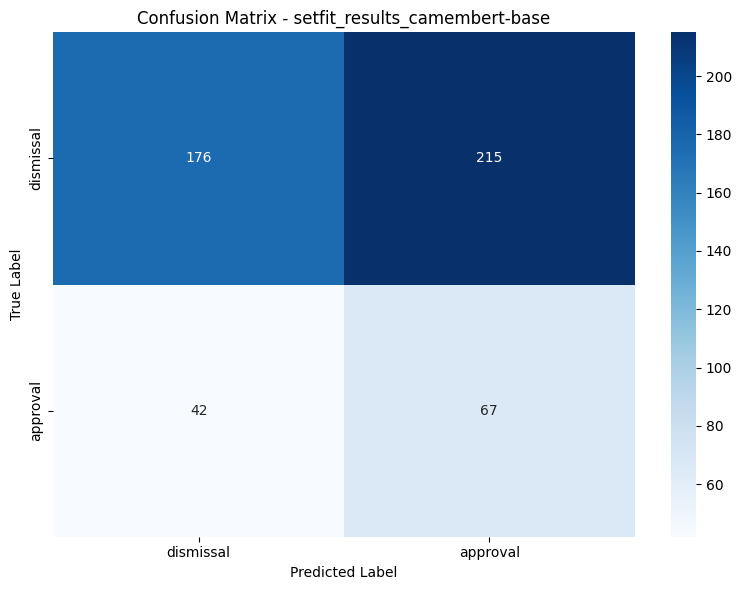

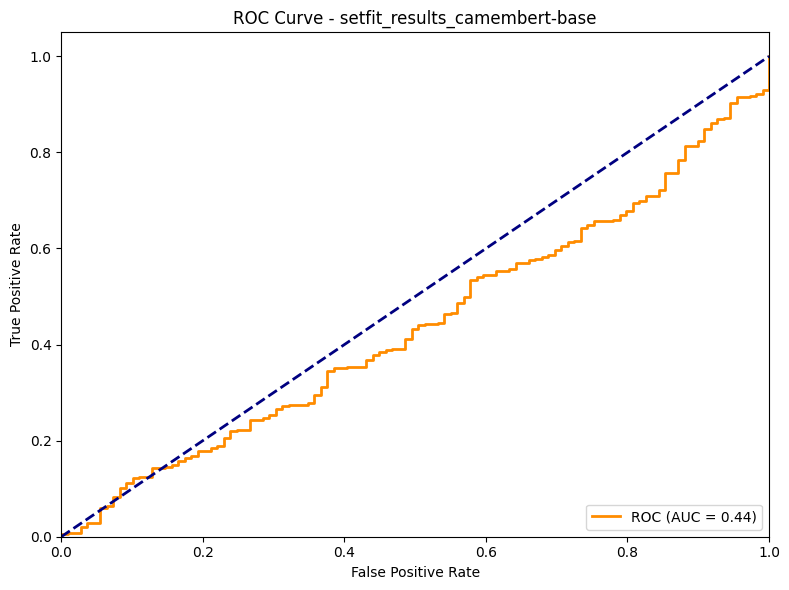

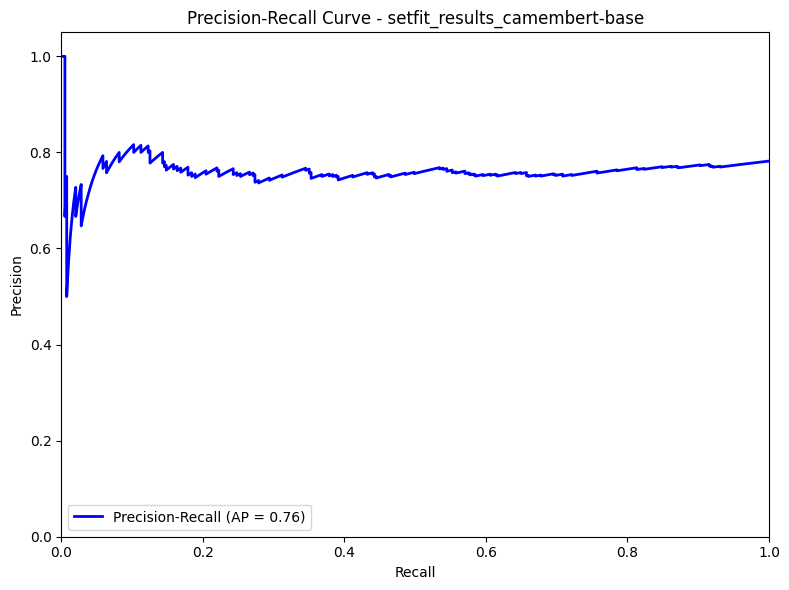

In [ ]:
# Evaluate CamemBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_camembert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_camembert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Model loaded from: models/part_2/a/setfit_best_juribert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal']
Predicted probabilities: [0.0007851355832424193, 0.0027032766031455176, 0.8364745607891187, 0.001584487507313795, 0.04609067038174123, 0.008428140010002723, 0.3586430690073332, 0.9829228549889099, 0.0008136889563317162, 0.0016749083397561162] 

              precision    recall  f1-score   support

   dismissal       0.77      0.62      0.69       391
    approval       0.20      0.35      0.26       109

    accuracy                           0.56       500
   macro avg       0.49      0.49      0.47       500
weighted avg       0.65      0.56      0.60       500



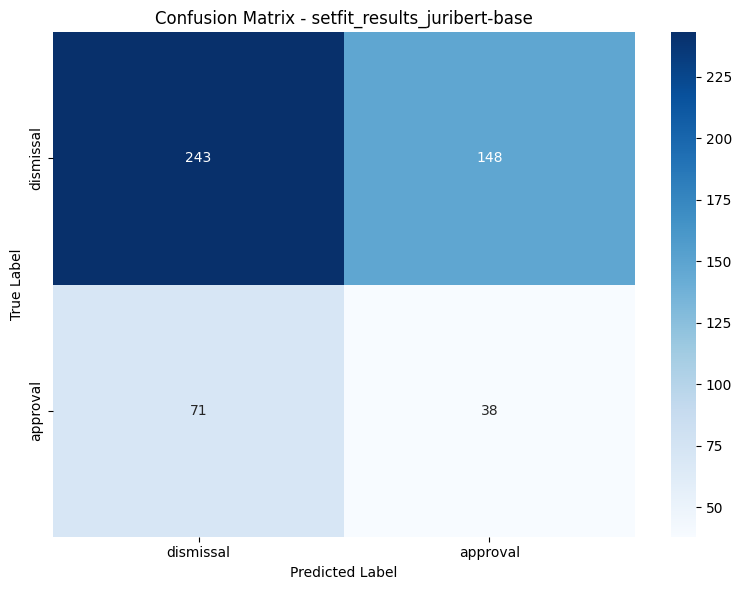

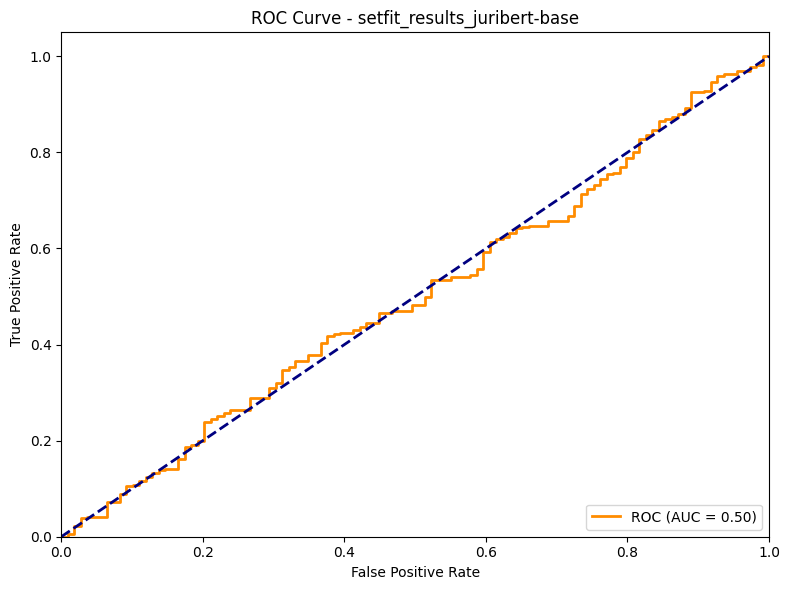

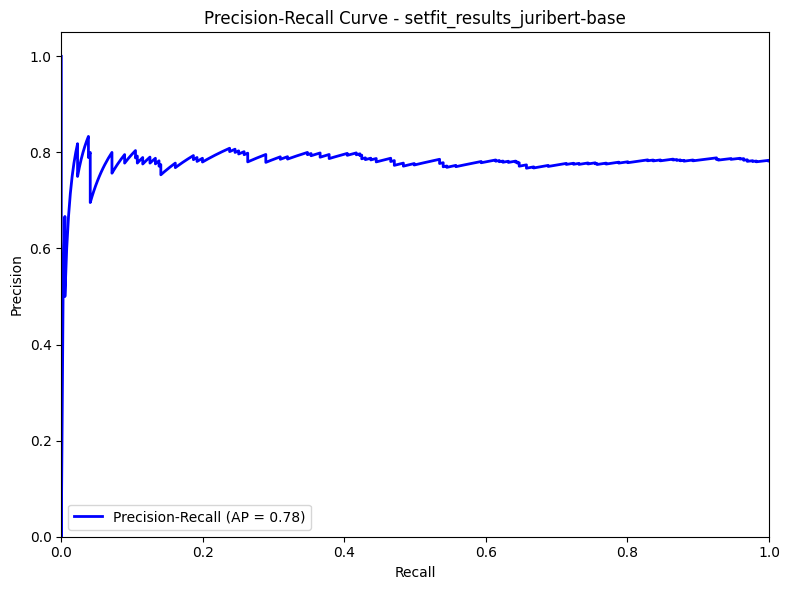

In [ ]:
# Evaluate JuriBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_juribert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_juribert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

### Models with standard fine-tuning

Loading model from: models/part_2/a/cls_fine_tuning_camembert-base/checkpoint-10
Loading tokenizer from: almanach/camembert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned almanach/camembert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.78      0.74      0.76       391
    approval       0.20      0.24      0.22       109

    accuracy                           0.63       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.65      0.63      0.64       500



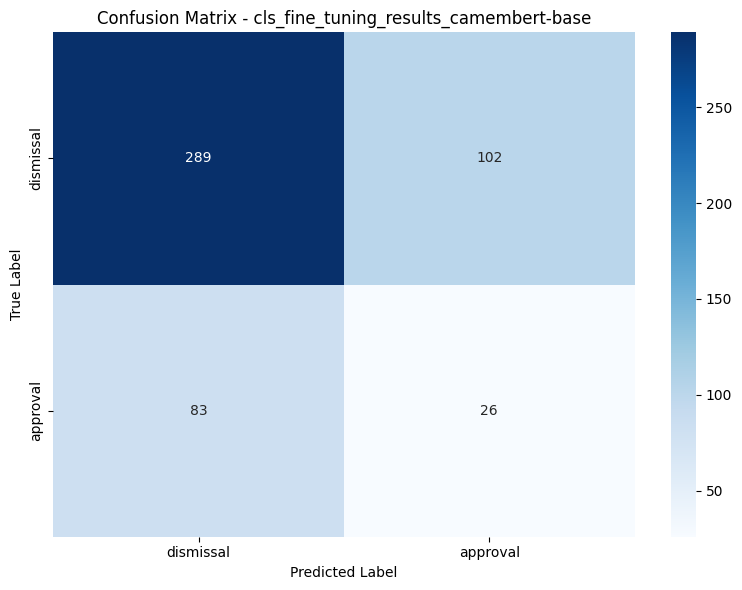

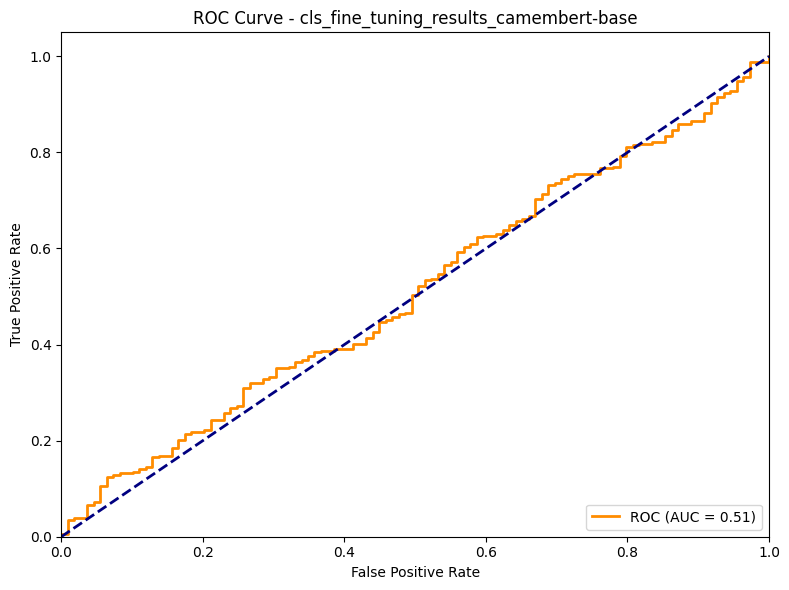

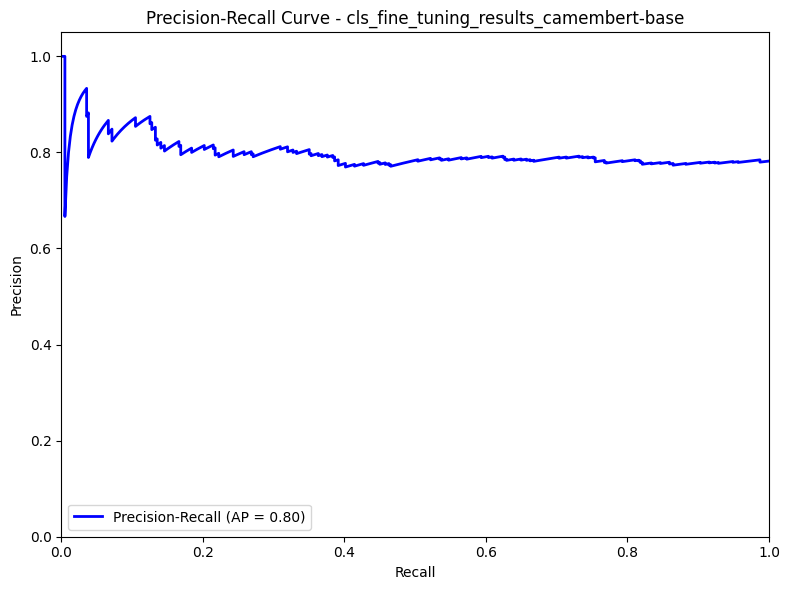

In [ ]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "almanach/camembert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 10
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_juribert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Loading model from: models/part_2/a/cls_fine_tuning_juribert-base/checkpoint-4
Loading tokenizer from: dascim/juribert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned dascim/juribert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.80      0.80      0.80       391
    approval       0.27      0.27      0.27       109

    accuracy                           0.68       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.68      0.68      0.68       500



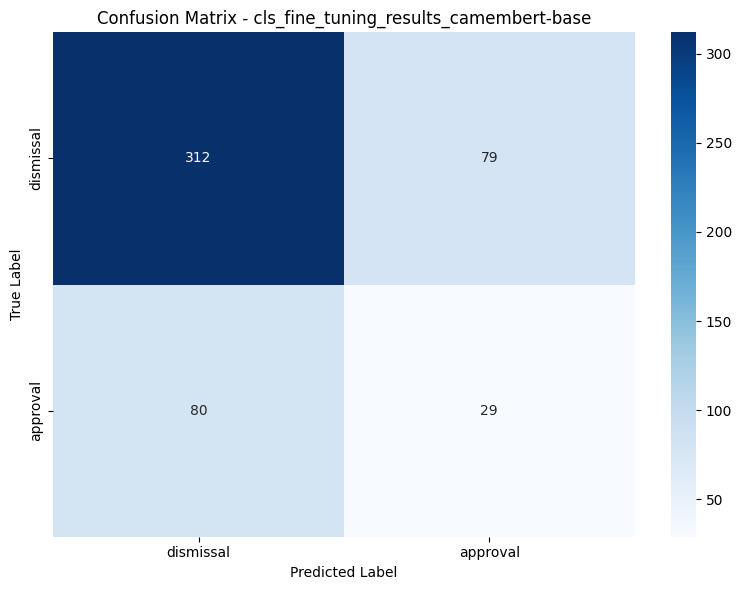

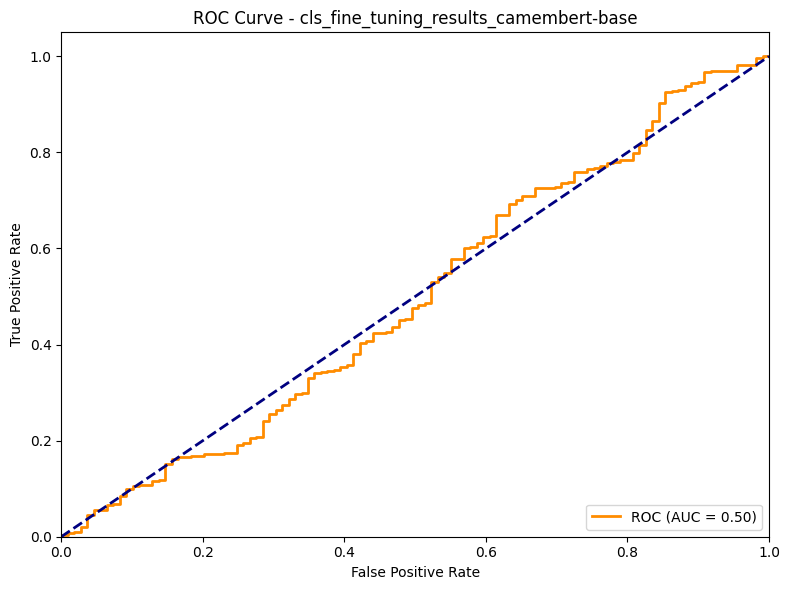

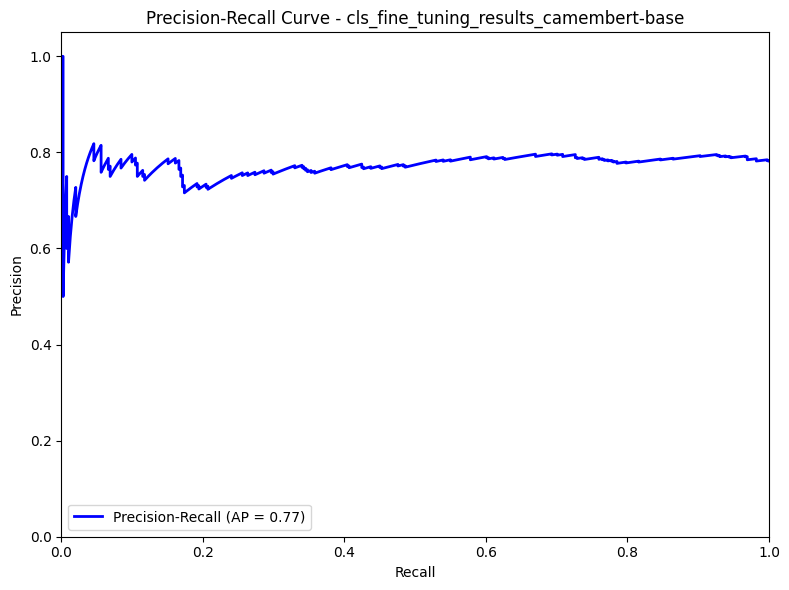

In [ ]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "dascim/juribert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 4
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_juribert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

## 1.4. Conclusions

# 2. Dataset Augmentation

Outline of the intermediate tasks: We want a fully automated pipeline. A good candidate is Easy Data Augmentation (EDA) or back-translation via open‐source MT models.
1. Choose Technique(s)
   - Easy Data Augmentation techniques (random insertion, deletion, swap).
   - Random synonym substitution (WordNet or fastText).
   - Back-translation: FR → EN → FR using MarianMT or opus-MT.
2. Implement & Generate
   - For each of the 32 labeled examples, generate k augmented pseudo-examples (e.g. k=5).
   - Deduplicate and filter (e.g. reject if new text <50% overlap).
3. Merge & Re-split
   - Combine original 32 + synthetic N = 32×k examples.
   - Re-run the same CV split strategy, ensuring augmented copies of a given original stay in the same fold.
4. Re-train BERT
   - Exactly the same hyperparams as in (a).
   - Track performance uplift vs. the baseline.
5. Analysis
   - Compare metrics: ΔAccuracy, ΔF1.
   - Ablation: EDA vs. back-translation vs. combined.
   - Qualitative: inspect a few synthetic samples.

# 3. Zero-Shot Learning with LLM

We will try several models for ZSL exercise. Our API access comes from groq.com, which has a wide variety of LLMs. The process is quite slow, and since the model runs on Groq’s servers, we cannot move inference to our local CUDA GPU.

In our prompt, we instruct the LLM to return a valid JSON object ({ "label": 0/1 }) to ensure easier parsing and consistency across runs. All the instructions and parameters are contained in the llm_config JSON in the config_files directory. We set the "default_label" to 0 (majority class) which the model will use if an error occurs either while getting a response from the LLM or parsing JSON output.

In [10]:
client = Groq(api_key=os.getenv("GROQ_API_KEY")) 

In [11]:
with open('config_files\llm_config.json') as f:
    config = json.load(f)

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\matia\AppData\Local\Temp\ipykernel_7996\1578043313.py:1: SyntaxWarning: invalid escape sequence '\l'
  with open('config_files\llm_config.json') as f:


### DeepSeek 90b model

In [12]:
import time
import tqdm


def process_batch(test_df, batch_size=10):
    y_pred, y_true = [], []
    for i in range(0, len(test_df), batch_size):
        batch = test_df.slice(i, min(batch_size, len(test_df) - i))
        for case in tqdm.tqdm(batch.iter_rows(named=True)):
            y_true.append(case['labels'])
            y_pred.append(classify_case(case['text']))
            time.sleep(config.get("processing_settings", {}).get("delay_between_requests", 0))
    return y_true, y_pred

# Sample a subset of the test data to evaluate
test_sample = test_df.sample(100, seed=seed)

In [ ]:
# Run prediction with DeepSeek
y_true1, y_pred1 = process_batch(test_sample, batch_size=config.get("processing_settings", {}).get("batch_size", 10))

Metrics calculated for: zero_shot_llm

Metrics for zero_shot_llm

Accuracy: 87.00%

Precision: 0.00%

Recall: 0.00%

F1 Score: 0.00%


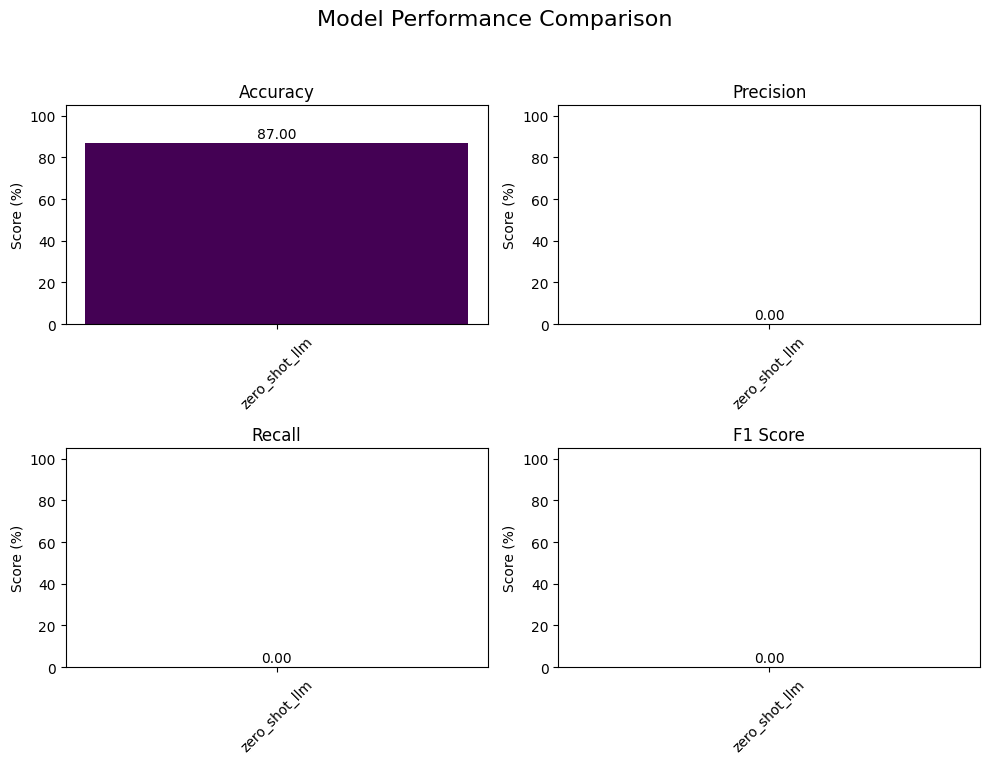

In [ ]:
# Calculate and display metrics
metrics.run(y_true1, y_pred1, 'zero_shot_llm', average='binary')
metrics.print_results()
metrics.plot()

Examining the predicted labels, we see that the LLM has classified every single case as 0 (Dismissal). Hence the 87% accuracy, because we had 13 Approval (1) labels in the test dataset and 87 Dismissal (0) labels. Since our True Positive is zero, both Precision and Recall are zero. This tells us that without examples, context or any other instructions that would help the LLM to make a correct ruling on the case, the model is unable to predict the correct label.

To carry out another check, we asked a thinking model (DeepSeek) to make a ruling on a case that was approved (label 1) and provided it's reasoning for assigning a label.

In [15]:
case_text = "Faits  A AA 1967 et BA 1945 tous deux ressortissants du RoyaumeUni se sont mariés en 2011 Ils ont un enfant commun C 2007 AA est également la mère dun enfant majeur issu dune précédente relation à savoir D 1998 B Ba A la suite de difficultés conjugales lépouse a formé une requête de mesures protectrices de lunion conjugale le 18 juin 2014 Les parties ont ensuite déposé une requête commune de divorce avec accord complet le 8 septembre 2014 Après un échange de correspondances mettant en évidence limpossibilité des parties de parvenir en réalité à un accord complet sur les effets accessoires du divorce le Président du Tribunal civil de larrondissement de La Côte ciaprès le Tribunal darrondissement a rejeté la requête par courrier du 26 août 2015 Bb En parallèle à léchange de correspondances susmentionné lépoux a déposé une requête de mesures protectrices de lunion conjugale le 24 août 2015 sollicitant notamment la garde exclusive de lenfant C Lépouse a à son tour déposé une requête le 26 août 2015 concluant notamment à lattribution de la garde de lenfant Lors dune audience tenue le 26 novembre 2015 les parties ont convenu de mettre en oeuvre le Service de protection de la jeunesse ciaprès SPJ afin quil établisse un rapport sur les conditions de vie de C auprès de chaque parent en vue de lattribution de la garde et quil détermine si une garde alternée était envisageable Bc Par acte du 30 janvier 2016 la mère a requis lautorisation de déplacer la résidence habituelle de lenfant C au RoyaumeUni à partir du 28 juin 2016 Bd Par prononcé de mesures protectrices de lunion conjugale du 21 avril 2016 rendu à la suite de laudience du 26 novembre 2015 le Président du Tribunal darrondissement a notamment autorisé les époux à vivre séparés pour une durée indéterminée I confié la garde de lenfant C à la mère II et attribué un libre et large droit de visite au père III et IV Be Le 12 mai 2016 une audience a eu lieu afin dexaminer la requête de la mère du 30 janvier 2016 concernant le déplacement de la résidence habituelle de lenfant Lors de cette audience la mère a retiré sa requête tout en se réservant le droit de déposer une nouvelle demande à la suite de la communication du rapport du SPJ Bf Par arrêt du 27 juin 2016 le Juge délégué de la Cour dappel civile du Tribunal cantonal du canton de Vaud ciaprès la Cour dappel civile a rejeté lappel formé par le père contre le prononcé du 21 avril 2016 Bg Le 18 juillet 2016 E et F respectivement assistante sociale et chef de lUnité évaluation et missions spécifiques auprès du SPJ ont établi un rapport sur la situation de C qui concluait en substance à lattribution de la garde à la mère si celleci demeurait en Suisse ou si tel nétait pas le cas à lattribution de la garde au père Bh Par requête de mesures protectrices de lunion conjugale du 22 août 2016 la mère a conclu préalablement à ce que le rapport du SPJ soit écarté de la procédure et principalement à ce quelle soit autorisée à déplacer la résidence habituelle de lenfant au RoyaumeUni dès le prononcé rendu Par courrier du 31 août 2016 le Président du Tribunal darrondissement a informé les parties quil nentendait pas écarter de la procédure le rapport du SPJ Bi Le 27 septembre 2016 lépoux a déposé une requête unilatérale de divorce auprès du Tribunal darrondissement Par courrier du 29 septembre 2016 lépouse a requis la suspension de la procédure de divorce en Suisse au motif quelle avait ouvert une telle procédure au RoyaumeUni le 12 septembre précédent Bj Ayant été informé du fait que le domicile de lenfant avait été déplacé à U France le père a déposé une requête de mesures superprovisionnelles et provisionnelles urgentes le 30 septembre 2016 concluant à ce quil soit fait interdiction à la mère de quitter le territoire suisse avec lenfant C et de déplacer la résidence de celui-ci au RoyaumeUni ou ailleurs et à ce quil soit ordonné à la mère de lui remettre immédiatement lenfant dont il aurait désormais la garde ainsi que ses documents didentité et tout autre document de voyage Par ordonnance de mesures superprovisionnelles du 30 septembre 2016 le Président du Tribunal darrondissement a interdit à la mère de quitter le territoire suisse accompagnée de son fils C ainsi que de déplacer la résidence habituelle de celui-ci au RoyaumeUni ou ailleurs et lui a ordonné de déposer immédiatement le passeport la carte didentité le permis de séjour et tout autre document de voyage de lenfant auprès du greffe du Tribunal darrondissement Par courrier du 4 octobre 2016 la mère a informé le Président du Tribunal darrondissement quelle quitterait U le 11 octobre 2016 et logerait à partir de cette date chez une amie à V Suisse Le 10 octobre 2016 la mère a déposé le passeport de C au greffe du Tribunal darrondissement Bk Une audience sest tenue le 10 novembre 2016 au cours de laquelle lassistante sociale E a été entendue C Par prononcé de mesures protectrices de lunion conjugale et ordonnance de mesures provisionnelles du 15 décembre 2016 la VicePrésidente du Tribunal darrondissement a notamment dit que la résidence de lenfant C devait demeurer en Suisse I a interdit en conséquence à la mère de déplacer la résidence habituelle de lenfant au RoyaumeUni ou ailleurs sans laccord exprès du père II a dit que les papiers didentité de lenfant resteraient déposés auprès du greffe du Tribunal darrondissement III a confié la garde de lenfant à sa mère aussi longtemps que celleci resterait domiciliée en Suisse IV a dit que le père bénéficierait dun libre et large droit de visite à exercer dentente entre les parties V ou à défaut dentente à raison dun weekend sur deux du vendredi soir au lundi matin chaque semaine du lundi aprèsmidi à la sortie de lécole au mardi matin à la rentrée de lécole ainsi que durant la moitié des vacances scolaires et jours fériés VI Par arrêt du 10 mai 2017 la Juge déléguée de la Cour dappel civile a rejeté lappel de la mère D Par acte du 14 juin 2017 la mère exerce un recours en matière civile au Tribunal fédéral Elle conclut principalement à ce quelle soit autorisée à déplacer immédiatement la résidence habituelle de lenfant C au RoyaumeUni à ce que le droit de visite du père soit fixé en fonction de la date du départ définitif et à ce quil soit ordonné au Tribunal darrondissement de lui restituer immédiatement les papiers didentité de lenfant Subsidiairement elle conclut à lannulation de larrêt querellé et au renvoi de la cause à lautorité cantonale pour nouvelle décision dans le sens des considérants Des observations nont pas été requises."

try:
    completion = client.chat.completions.create(
        model="deepseek-r1-distill-llama-70b",
        messages=[
            {
                "role": "user",
                "content": f"Sur la base des seuls faits de l'affaire {case_text}, déterminez si l'affaire doit être rejetée (0) ou approuvée (1). Le rejet (0) signifie que le tribunal est défavorable à la demande et que le requérant a enfreint certaines lois. L'approbation (1) signifie que le tribunal est favorable à la demande, le requérant gagne l'affaire. Analysez l'affaire et répondez par un seul chiffre : 0 pour le rejet ou 1 pour l'approbation. N'indiquez PAS 0 par défaut si vous n'êtes pas sûr. Attribuez l'étiquette la plus probable. Expliquez les raisons pour lesquelles vous avez choisi cette étiquette."
            }
        ],
        temperature=0.5,
        max_completion_tokens=4096,
        top_p=0.95,
        stream=True,
        stop=None,
    )
    
    for chunk in completion:
        print(chunk.choices[0].delta.content or "", end="")
except Exception as e:
    print(f"Error occurred: {e}")

<think>
Okay, let's try to figure out whether this case should be approved (1) or rejected (0). So, the case involves a couple who got married in 2011, have a child C born in 2007, and another child D from a previous relationship. They started having marital issues, and the wife filed for protective measures in 2014. They both tried to file for divorce with an agreement but couldn't reach one. 

Then, both parents filed requests for custody. They agreed to involve the Service de Protection de la Jeunesse (SPJ) to assess the living conditions for the child C. The SPJ report concluded that if the mother stayed in Switzerland, she should have custody, but if she left, the father should. 

The mother tried to move the child to the UK, but the court initially rejected her request. The father then filed an urgent request to prevent the mother from moving the child. The court ordered the mother to deposit the child's travel documents and prohibited her from moving the child's residence withou

The LLM, again, assigned label 0 (dismissal), which means that it sided with the lower courts rather than the appellant. To summarize the reasons it provided:
- The lower courts have consistently ruled against it, citing the best interests of the child and the father's rights.
- Given the consistent lower court rulings, the assessment of the Youth Protection Service, and the mother's disregard for court orders, the Federal Supreme Court is likely to reject her appeal.

We see that the LLM could be biased by the fact that the previous rulings by lower courts have already dismissed the case. We can change the prompt to try to remove that bias. However, if two lower courts have dismissed the case based on it's facts, it's not surprising that the LLM is also prone to dismiss it based on the same facts.

We rerun the experiment with a new prompt (asking to ignore the previous rulings) and with another model.

### Gemma 9b (Google Gemini) LLM

In [ ]:
# Change model without touching config
config["model_settings"]["model_name"] = "gemma2-9b-it"

test_sample = test_df.sample(100, seed=seed)

y_true2, y_pred2 = process_batch(test_sample, batch_size=config.get("processing_settings", {}).get("batch_size", 10))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Metrics calculated for: zero_shot_llm

Metrics for zero_shot_llm

Accuracy: 87.00%

Precision: 0.00%

Recall: 0.00%

F1 Score: 0.00%


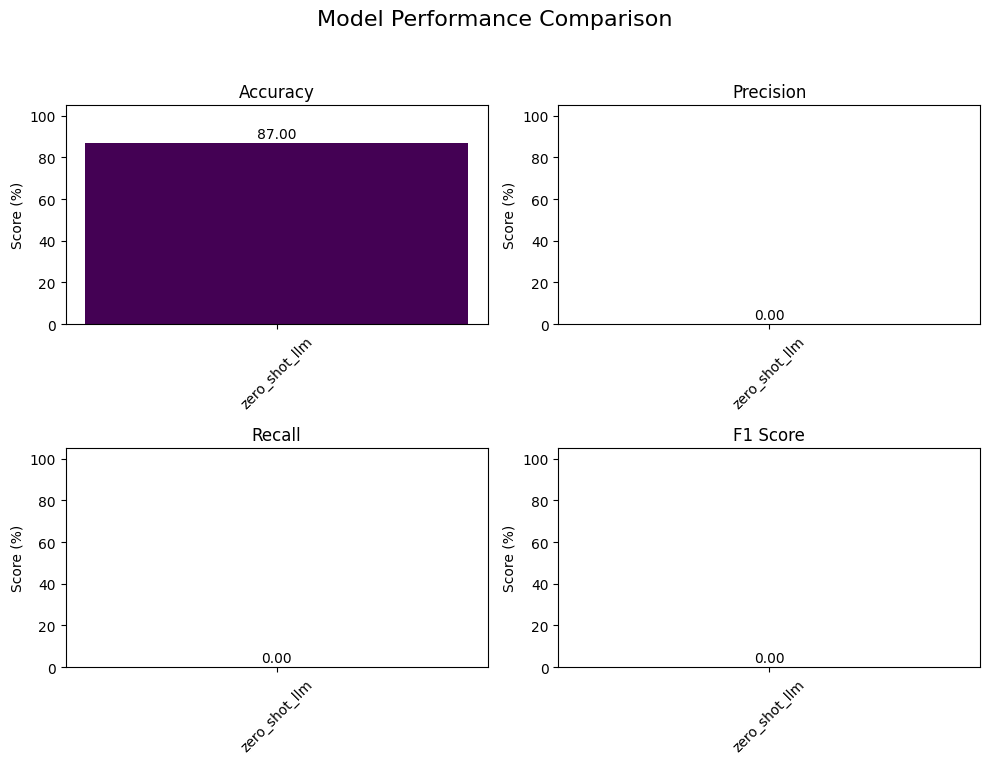

In [ ]:
# Calculate and display metrics
metrics.run(y_true2, y_pred2, 'zero_shot_llm', average='binary')
metrics.print_results()
metrics.plot()

Just like in the previous run, Gemma also classified all cases as (0). It likely proves our assumption that these court cases present an almost impossible task for AI because all the cases in our database are too controversial to be resolved in the lower chambers, that's how they ended up in the Federal Supreme Court of Switzerland (FSCS). Ruling on these borderline cases requires not only proper reasoning (human), but also advanced domain knowledge, including constitutions and legal precedence of several countries.

# 4. Data Generation with LLM

In [18]:
import asyncio
from tqdm.auto import tqdm
from groq import AsyncGroq
import nest_asyncio

nest_asyncio.apply()

In [19]:
client = AsyncGroq(api_key=os.environ.get("GROQ_API_KEY"))

We decided to go with Meta's llama-3.3-70b-versatile, because according to documentation, of all the models available through Groq, Llama seems to be the best fit for several reasons:
- It's a multilingual model with explicit support for French, and it is instruction-tuned for text generation tasks.
- It is suitable for the legal domain.
- Larger parameter size (70B) means better fluency and reasoning, especially for complex legal texts.

We used FSL and included two positive and two negative examples in the prompt to demonstrate to the LLM an approximate structure and style of a case.


In [66]:
async def generate_labeled_case(client, label_type):
    """Generate a single legal case with the specified label (0 or 1)"""
    
    if label_type == 0:
        instruction = """Générer un cas juridique réaliste pour le Tribunal fédéral suisse qui devrait être rejeté (0) par le tribunal.
        L'affaire doit porter sur des détails où le demandeur a violé des lois ou des règlements.
        Commencez par « Faits : » suivi de détails pertinents tels que les participants à l'affaire, les événements, les violations.
        Faites en sorte que l'affaire soit réaliste. N'utilisez que les faits, sans jugement.
        Exemple: A. A._ SA a entrepris des travaux de rénovation dans des appartements d'un immeuble situé sur la parcelle n o 2346 de la commune de Vernier dont elle est propriétaire. Lors d'une inspection le 20 juin 2013, le Service de toxicologie de l'environnement bâti (ci-après: STEB) a constaté que deux chantiers de rénovation avaient été entrepris aux 15ème et 22ème étages de cet immeuble, sis au 8 de l'avenue du Lignon; selon le procès-verbal d'inspection, des interventions sans précaution, en l'absence de diagnostic amiante avant travaux, avaient été entreprises sur des matériaux susceptibles de contenir de l'amiante. Le laboratoire B._ SA a procédé à l'examen d'échantillons prélevés sur place par le STEB et a constaté, dans son rapport du 26 juin 2013, la présence d'amiante chrysotile dans la colle ainsi que dans les dallettes de sol des cuisines des appartements. Par décision du 26 juin 2013 (déclarée exécutoire nonobstant recours), le Département genevois de l'intérieur, de la mobilité et de l'environnement (devenu depuis lors le Département de l'environnement, des transports et de l'agriculture [DETA]), soit pour lui le STEB, a ordonné la suspension immédiate des chantiers et la réalisation d'une expertise amiante; A._ devait mandater une entreprise de désamiantage reconnue pour retirer les matériaux amiantés qui avaient été endommagés par les travaux; la reprise des travaux était conditionnée à la remise de divers rapports. Le 16 octobre 2013, le STEB a constaté, lors d'une nouvelle inspection locale, que A._ n'avait pas réalisé d'expertise amiante et que les travaux étaient en cours d'achèvement au 15 ème étage et achevés au 22 ème étage, l'appartement étant occupé par une locataire (cf. procès-verbaux d'inspection du 16 octobre 2013). Le même jour, le STEB a inspecté un chantier de rénovation d'un appartement du 14ème étage; il a constaté que des interventions sans précaution, en l'absence de diagnostic amiante avant travaux, avaient été entreprises sur des matériaux susceptibles de contenir de l'amiante. Le DETA a ordonné, le 18 octobre 2013, les mêmes mesures que celles exigées dans sa décision du 26 juin 2013 (suspension des travaux et réalisation d'une expertise amiante). Le DETA a ordonné, par décision du 22 octobre 2013, l'assainissement de cet appartement dès lors que de l'amiante chrysotile avait été identifiée par le laboratoire B._ dans les colles de la cuisine et de la véranda de l'appartement. Le 13 novembre 2013, le DETA a ordonné l'assainissement d'un appartement du 19 ème étage dont la rénovation avait été entreprise sans diagnostic amiante avant travaux et dans lequel de l'amiante chrysotile avait été identifiée par le laboratoire B._ dans la colle et les dallettes de sol de la cuisine, ainsi que dans du mastic vitrier et de la poussière du sol du palier. B. Par décision du 26 janvier 2015, le DETA a infligé à A._ une amende administrative de 200'000 francs, en raison du non-respect des décisions des 26 juin, 18 et 22 octobre 2013. Le Tribunal administratif de première instance du canton de Genève a, par jugement du 16 septembre 2015, admis partiellement le recours formé par A._ contre cette décision et a fixé le montant de l'amende à 105'000 francs. Par arrêt du 29 novembre 2016, la Chambre administrative de la Cour de justice du canton de Genève a rejeté le recours formé par A._ contre le jugement du 16 septembre 2015. C. Agissant par la voie du recours en matière de droit public, A._ demande au Tribunal fédéral de réformer l'arrêt entrepris en ce sens qu'aucune amende ne lui soit infligée, subsidiairement que l'amende soit fixée au maximum à 5'000 francs. A titre encore plus subsidiaire, elle conclut au renvoi de la cause à l'instance précédente pour nouvelle décision. La cour cantonale n'a pas d'observations à formuler et se réfère aux considérants de son arrêt. Aux termes de ses observations, le DETA a conclu au rejet du recours. La recourante n'a pas répliqué.
        Exemple: A. Par contrat du 6 mars 2009, A._ a remis à bail à H.X._ une maison individuelle, avec garage, à St-Prex. Le loyer mensuel était fixé à 4'150 fr. La bailleresse a résilié le bail le 14 novembre 2013 pour le 31 mars 2014. B. H.X._ et son épouse (ci-après : les locataires) ayant saisi la Commission de conciliation, les parties ont passé devant celle-ci une transaction le 13 mars 2014: la résiliation du bail a été reconnue valable et acceptée (ch. 1), une unique prolongation de bail a été prévue jusqu'au 30 septembre 2016 (ch. 2) et les locataires se sont engagés à quitter les locaux loués au plus tard le 30 septembre 2016 à midi, libre de toute personne et de tout objet (ch. 3), les locataires pouvant les quitter en tout temps, moyennant un préavis de 30 jours pour la fin d'un mois (ch. 4). Selon le procès-verbal de la conciliation, cette transaction a les effets d'une décision entrée en force, conformément à l'art. 208 al. 2 CPC. Le 6 octobre 2016, les locataires n'ayant pas quitté les lieux pour l'échéance prévue, la bailleresse a requis, du Juge de paix du district de Morges, l'exécution forcée de la transaction judiciaire du 13 mars 2014. Les locataires ont conclu principalement à l'irrecevabilité, subsidiairement au rejet de la requête d'exécution forcée et plus subsidiairement à ce que la transaction judiciaire soit exécutée d'ici au 31 mars 2017. Par ordonnance du 22 décembre 2016, la Juge de paix du district de Morges a ordonné l'exécution forcée du ch. 3 de la transaction et fixé la date de l'exécution forcée par l'huissier de paix ou son remplaçant, sous la présidence du juge de paix, au 2 février 2017 à 9 h, ordonnant aux agents de la force publique de concourir à l'exécution forcée s'ils en sont requis par l'huissier de paix et précisant qu'il sera procédé au besoin à l'ouverture forcée. Statuant par arrêt du 19 janvier 2017, la Chambre des recours civile du Tribunal cantonal du canton de Vaud a rejeté le recours et confirmé l'ordonnance attaquée. C. Contre cet arrêt, les locataires ont interjeté un recours en matière civile et un recours constitutionnel subsidiaire le 30 janvier 2017, concluant principalement à sa réforme en ce sens que la requête d'exécution forcée déposée par la bailleresse est rejetée et, subsidiairement, à son annulation et au renvoi de la cause à la cour cantonale pour nouvelle décision dans le sens des considérants. Par ordonnance du 31 janvier 2017, il a été ordonné que jusqu'à décision sur la requête d'effet suspensif, aucune mesure d'exécution de la décision attaquée ne soit prise. La partie intimée n'a pas été invitée à répondre. Par courrier du 22 février 2017, ayant appris que la bailleresse était décédée le 11 mars 2016, les recourants ont conclu à l'irrecevabilité et à la nullité de la requête d'exécution, pour violation de l'art. 59 CPC et des art. 29 s. Cst. La partie intimée s'est déterminée le 2 mars 2017, invoquant que la bailleresse aurait toujours été inscrite au registre foncier le 22 octobre 2016. Les recourants ont répliqué que la radiation au registre foncier serait intervenue le 28 juillet 2016.
        """
    else:
        instruction = """Générer un cas juridique réaliste pour le Tribunal fédéral suisse qui devrait être approuvé (1) par le tribunal.
        L'affaire doit porter sur des détails pour lesquels le demandeur a une revendication légitime étayée par des faits.
        Commencez par « Faits : » suivi de détails pertinents tels que les participants à l'affaire, les événements, les violations.
        Faites en sorte que l'affaire soit réaliste. N'utilisez que des faits, sans jugement.
        Exemple: A. X._, né en 1949, est au bénéfice d'un titre postgrade suisse en psychiatrie et psychothérapie et est autorisé à pratiquer à titre indépendant dans le canton de Vaud depuis 2004. Le 3 mai 2016, le Chef du Département de la santé et de l'action sociale du canton de Vaud (ci-après: le Département de la santé) lui a infligé un blâme, ainsi qu'une amende de 10'000 fr. et a ordonné que la sanction soit publiée dans la Feuille d'avis officielle du canton de Vaud (ci-après: FAO); il a également astreint l'intéressé à un suivi thérapeutique, avec un rapport trimestriel de son psychiatre au Médecin cantonal. Ces mesures sanctionnaient le comportement de X._, qui avait eu des relations sexuelles avec une de ses patientes (après la fin de la thérapie) en 2015. La décision du 3 mai 2016 signalait également que l'intéressé avait entretenu des relations sexuelles avec une autre de ses patientes en 2003 et 2005, tout en mentionnant que les faits relatifs à cette autre affaire étaient prescrits et que la décision ne concernait que les faits de 2015. B. Par arrêt du 18 octobre 2016, la Cour de droit administratif et public du Tribunal cantonal du canton de Vaud (ci-après: le Tribunal cantonal) a rejeté le recours que X._ avait déposé à l'encontre de la décision du 3 mai 2016 en tant qu'elle ordonnait la publication de la sanction prononcée. C. Agissant par la voie du recours en matière de droit public, X._ demande au Tribunal fédéral, sous suite de frais et dépens, de réformer l'arrêt attaqué en ce sens que la publication dans la FAO de la décision du 3 mai 2016 du Département de la santé est interdite; subsidiairement, d'annuler l'arrêt attaqué et de renvoyer la cause au Tribunal cantonal pour une nouvelle décision dans le sens que ladite publication est interdite. Le Service de la santé publique du canton de Vaud conclut au rejet du recours. Le Tribunal cantonal se réfère aux considérants de l'arrêt attaqué. Par ordonnance du 13 décembre 2016, le Président de la IIe Cour de droit public a considéré que la demande d'effet suspensif était sans objet. X._ s'est encore prononcé par écriture reçue par le Tribunal fédéral le 11 janvier 2017.
        Exemple: A. A.a. A._ est l'actionnaire majoritaire à 95 percent et le président-directeur général de C._, société de droit saoudien spécialisée dans le développement et la gestion de projets d'investissement, dont le siège se trouve en Arabie saoudite. Le reste des actions est détenu par l'un de ses fils. A.b. Sur requête de B._ et sur la base d'une sentence arbitrale du 31 juillet 2012, le Tribunal de première instance du canton de Genève (ci-après: Tribunal de première instance) a, par ordonnance du 14 novembre 2012, ordonné le séquestre des biens de C._ (séquestre n° bbbb), limité à la somme de xx'xxx'xxx fr. correspondant à la contrevaleur de xx'xxx'xxx USD, portant sur les avoirs déposés auprès de E._ Ltd (E._ AG; ci-après: E._) à Genève sur les comptes n° cccc au nom de A._ (anciennement: compte n° xxxx auprès de D._ Ltd et n° dddd (compte sur lequel les intérêts du compte n° cccc étaient versés), ou sur tout autre compte au nom de A._ ayant bénéficié de fonds provenant de comptes de C._, et appartenant en réalité à C._. A._ a formé opposition à l'ordonnance de séquestre susmentionnée, soutenant notamment que le séquestre touchait des droits patrimoniaux dont il est titulaire. A.c. Par jugement du 2 mai 2013, le Tribunal de première instance a rejeté l'opposition, considérant qu'un montant total de xx'xxx'xxx USD avait été transféré du compte de C._ sur le compte de A._, que ce dernier n'avait fourni aucune explication sur les motifs pour lesquels C._ lui aurait versé cet argent, et qu'il apparaissait donc vraisemblable que les avoirs susvisés appartenaient à C._. A.d. B._ a validé le séquestre par une réquisition de poursuite par voie de saisie. A.e. Par courrier du 15 octobre 2013, E._ a informé l'Office des poursuites du canton de Genève (ci-après: Office) qu'elle ferait savoir dans un délai raisonnable si elle avait un droit de gage à faire valoir sur le compte séquestré dès qu'elle aurait connaissance de l'identité du créancier séquestrant. S'agissant d'un autre compte n° aaaa également détenu par C._ et faisant l'objet du séquestre n° zzzz requis par B._, elle a toutefois indiqué avoir fait valoir son droit de gage dans le cadre d'une action en revendication initiée par ce dernier devant les tribunaux bâlois. Celui-ci avait déjà été intégralement reconnu en première instance et la procédure était pendante devant la Cour d'appel de Bâle-Ville. L'Office a refusé de communiquer l'identité du créancier séquestrant par courrier du 21 octobre 2013. Dans sa réponse du 1 er novembre 2013, E._ a déclaré que son ignorance de l'identité du créancier séquestrant ne lui permettait que difficilement de cerner l'étendue et le fondement des droits qu'elle devait faire valoir mais que de tels droits existaient à tout le moins. Par courrier du 11 novembre 2013, E._ a listé les avoirs détenus auprès d'elle par A._ et C._ et sur lesquels elle déclarait bénéficier d'un droit de gage. Par courrier du 12 septembre 2014, E._ a rappelé à l'Office que, s'agissant du séquestre n° bbbb, elle lui avait déjà fait part des droits de gage dont elle bénéficiait sur l'ensemble des avoirs séquestrés, exception faite d'un montant maximal de xx'xxx'xxx USD pour lesquels B._ bénéficiait d'un droit de gage prioritaire au sien sur le compte n° eeee. B. B.a. Parallèlement, par courrier du 10 décembre 2012 adressé à l'Office, A._ a adressé une déclaration de revendication au sens de l'art. 106 LP, alléguant être le seul titulaire des comptes ouverts auprès de E._ et objets du séquestre n° bbbb. Par acte du 27 mars 2013, B._ a formé contre A._ une action en contestation de revendication tendant principalement à ce que la revendication du droit de propriété de ce dernier sur les comptes n os cccc et dddd auprès de E._, ou tout autre compte séquestré à son nom conformément à l'ordonnance de séquestre n° bbbb, soit écartée et à ce qu'il soit dit et constaté que ledit séquestre irait sa voie. A._ s'est opposé à l'action en contestation de revendication, concluant notamment au prononcé de la levée immédiate du séquestre n° bbbb. B.b. Par jugement du 4 février 2015, le Tribunal de première instance a préalablement déclaré recevable l'action en contestation de revendication déposée le 27 mars 2013 par B._ et, principalement, écarté la revendication de A._. Ce jugement a été confirmé par arrêt de la Cour de justice du canton de Genève du 16 octobre 2015 et le recours en matière civile formé contre cet arrêt a été rejeté par arrêt du Tribunal fédéral du 22 avril 2016 (5A_876/2015). C. Le 26 février 2014, sur la base de deux sentences arbitrales des 15 novembre 2012 et 9 août 2013, B._ a également requis et obtenu du Tribunal de première instance le séquestre des avoirs de A._ auprès de E._ (séquestre n° ffff). Le séquestre n° ffff a été validé par B._ par un commandement de payer notifié le 21 août 2014, poursuite n° gggg, portant sur une somme de xxx'xxx'xxx fr. xx. Ce séquestre n'a fait l'objet d'aucune opposition et la plainte dirigée contre le commandement de payer le validant a été rejetée. D. D.a. Par courrier du 13 novembre 2015, l'Office a rappelé à E._ que les délais de contestation n'avaient pas été ouverts s'agissant de sa prétention au motif qu'elle n'avait pas souhaité l'informer sur la portée du séquestre. Il a en outre relevé que, dans la mesure où le séquestre n° bbbb n'avait pas encore été converti en saisie définitive, sa prétention n'avait pas encore été communiquée aux parties. Par courrier du 30 novembre 2015, l'Office a informé E._ que le séquestre n° bbbb faisait l'objet d'une revendication d'un droit de propriété formée par A._ et qu'un recours au Tribunal fédéral était pendant (cf. supra B.b). Il a donc déclaré juger " opportun de ne pas procéder à l'ouverture des délais de contestation de revendication du droit de gage de E._ avant de connaître le résultat quant au droit de propriété soulevé par [A._] ". Par courrier du 22 décembre 2015, E._ a notamment sollicité d'être tenue informée dès que la procédure en revendication initiée par A._ serait close. Par courrier du 8 février 2016, E._ a, entre autres, rappelé avoir annoncé être au bénéfice d'un droit de gage sur les comptes n oseeee et hhhh détenus par A._ sur lesquels portait le séquestre n° bbbb, exception faite du droit de gage d'un montant maximal de xx'xxx'xxx USD dont bénéficiait B._ sur le compte n° eeee. Par courrier du 15 mars 2016, E._ a notamment informé l'Office qu'elle menait des pourparlers avec le créancier séquestrant, à savoir B._, afin de régler à l'amiable la question (" das Thema einvernehmlich zu erledigen ") de son droit de gage sur les avoirs séquestrés évoqué dans son courrier du 8 février 2016. Le 27 juin 2016, l'Office a invité E._ à lui indiquer la nature et la valeur de son droit de gage. Celle-ci a répondu le 28 juillet 2016 qu'elle s'était entendue avec le créancier séquestrant sur plusieurs points encore litigieux. Il en résultait que, dans le cadre des procédures de séquestre n os bbbb et ffff, elle avait fait valoir par courrier du 8 février 2016 des droits de gage pour des prétentions contre le débiteur séquestré en relation avec la procédure arbitrale ICC n° xxxxxx/xxx/xxx ainsi que la procédure devant le Tribunal de commerce de Paris n° xx/xxxxx. Pour ces créances, elle ne faisait plus valoir ses droits de gage. Elle rappelait que ses droits de gage subsistaient néanmoins et qu'ils étaient antérieurs aux séquestres. Elle se réservait par conséquent le droit de les revendiquer en application de l'art. 106 al. 2 LP jusqu'à la réalisation dans la mesure où elle aurait des prétentions garanties par ces droits à faire valoir contre le débiteur séquestré. En l'état, elle ne faisait toutefois pas valoir de telles prétentions en lien avec ces deux procédures de séquestre. Elle a réitéré ces propos dans un courrier du 17 novembre 2016, rappelant que si elle n'entendait actuellement pas faire valoir ses droits de gage, elle se réservait expressément le droit de le faire jusqu'à la réalisation effective des avoirs séquestrés en application de l'art. 106 al. 2 LP (" Aktuell nimmt [unsere Mandantin] ihre dem Arrest vorgehenden Pfandrechte nicht in Anspruch. Eine Inanspruchnahme bleibt aber bis zur tatsächlichen Verwertung ausdrücklich vorbehalten (Art. 106 Abs. 2 SchKG). "). D.b. Par courrier du 6 janvier 2017, notifié le 9 janvier 2017 à E._, l'Office, constatant que les avoirs séquestrés étaient désormais libres de toute revendication, l'a invitée à convertir en francs suisses le montant de xx'xxx'xxx.xx USD déposés sur les comptes visés par les deux séquestres et à les lui transférer. D.c. Par plainte expédiée le 19 janvier 2017, E._ a contesté cette décision devant la Chambre de surveillance des offices des poursuites et des faillites de la Cour de justice du canton de Genève (ci-après: Chambre de surveillance) et demandé que l'Office donne suite aux revendications qu'elle avait annoncées, tant en ce qui concernait les droits de gage revendiqués par elle-même, à savoir ses droits de gage sur la totalité des avoirs bancaires déposées sur les comptes n os xxxx et hhhh, que le droit de gage de B._ sur les avoirs bancaires déposés sur le compte n° eeee à concurrence d'un montant maximal de xx'xxx'xxx USD selon l'accord " Undertakings and Instructions " et d'ouvrir en conséquence les délais de contestation des revendications. Elle a requis à titre préalable l'octroi de l'effet suspensif. D.d. Par ordonnance du 3 février 2017, la Chambre de surveillance a rejeté la requête d'effet suspensif. E. Par acte du 13 février 2017, E._ forme un recours en matière civile au Tribunal fédéral contre cette ordonnance dont elle requiert principalement l'annulation et la réforme en ce sens que l'effet suspensif est octroyé à sa plainte. Subsidiairement, elle conclut à l'annulation de dite ordonnance et au renvoi de la cause à la Chambre de surveillance pour nouvelle décision au sens des considérants Préalablement, elle sollicite, à titre de mesures provisionnelles, que la mesure ordonnée par l'Office dans son courrier du 6 janvier 2017 soit suspendue jusqu'à droit connu sur le présent recours. F. Par ordonnance présidentielle du 2 mars 2017, les mesures provisionnelles requises ont été octroyées. Invités à se déterminer, la Chambre de surveillance s'est référée aux considérants de son ordonnance, l'Office s'est référé à ses observations du 17 février 2017 sur la plainte formée par E._ dans lesquelles il concluait au rejet de celle-ci, B._ a conclu au rejet du recours dans la mesure où il est recevable et A._ et C._ ont conclu à l'annulation de l'ordonnance querellée et à l'octroi de l'effet suspensif à la plainte. 
        """
    
    try:
        response = await client.chat.completions.create(
            model="meta-llama/llama-4-maverick-17b-128e-instruct", 
            messages=[{"role": "user", "content": instruction}],
            temperature=1,
            max_tokens=300
        )
        
        case_text = response.choices[0].message.content.strip()
            
        return {
            "case_text": case_text,
            "label": label_type
        }
    except Exception as e:
        print(f"Error generating case: {e}")
        await asyncio.sleep(2)
        return None

async def generate_labeled_dataset(n=100, ratio_positive=0.5, max_concurrent=3):
    """Generate a balanced dataset with n cases"""
    
    num_positive = int(n * ratio_positive)
    num_negative = n - num_positive
    
    semaphore = asyncio.Semaphore(max_concurrent)
    
    async def generate_with_semaphore(label):
        async with semaphore:
            return await generate_labeled_case(client, label)
    
    tasks = []
    for _ in range(num_negative):
        tasks.append(generate_with_semaphore(0))
    for _ in range(num_positive):
        tasks.append(generate_with_semaphore(1))
    
    print(f"Generating labeled cases...")
    results = []
    for task in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        result = await task
        if result:
            results.append(result)
    
    df = pl.DataFrame(results)
    
    df = df.sample(fraction=1.0, seed=42)
    
    return df

In [ ]:
async def main():
    # Generate 100 cases with approximately 50% label 0 and 50% label 1
    labeled_df = await generate_labeled_dataset(n=50, ratio_positive=0.5, max_concurrent=3)
    
    labeled_df.write_csv('data/synthetic_labeled_legal_cases.csv')
    print(f"Generated {len(labeled_df)} labeled synthetic legal cases and saved to CSV.")
    
    label_counts = labeled_df.group_by('label').count()
    print("\nLabel distribution:")
    for row in label_counts.iter_rows():
        label, count = row
        print(f"Label {label} ({'Approved' if label == 1 else 'Rejected'}): {count}")
    
    print("\nSample cases:")
    sample_df = labeled_df.sample(n=3, seed=42)
    for i, row in enumerate(sample_df.iter_rows(named=True)):
        print(f"\nCase {i} (Label: {row['label']}):")
        print(row['case_text'][:200] + "...")

await main()

Generating labeled cases...


  0%|          | 0/50 [00:00<?, ?it/s]

Error generating case: Error code: 429 - {'error': {'message': 'Rate limit reached for model `meta-llama/llama-4-maverick-17b-128e-instruct` in organization `org_01jt15wmf2ew28yd26r54946ss` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 6794, Requested 3456. Please try again in 42.508s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error generating case: Error code: 429 - {'error': {'message': 'Rate limit reached for model `meta-llama/llama-4-maverick-17b-128e-instruct` in organization `org_01jt15wmf2ew28yd26r54946ss` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 4658, Requested 3456. Please try again in 21.131999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Error generating case: Error code: 429 - {'error': {'message': 'Rate limit reached for mod

C:\Users\matia\AppData\Local\Temp\ipykernel_7996\2885421649.py:10: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  label_counts = labeled_df.group_by('label').count()


We kept exceeding the daily limit of free requests for a particular model, so we had to use several versions of Llama, DeepSeek and Gemma, and rerun the process several days in a row to generate enough synthetic cases. Then we concatenated all the saved CSV files to get the final synthetic dataset with 200 fake cases: 100 labeled "Approved" and 100 - "Dismissed".

In [7]:
# Load the synthetic dataset
synthetic_df_full = pl.read_csv('data/synthetic_combined.csv').drop_nulls(subset=['case_text'])

### Retrain BERT with synthetic data

In [ ]:
synthetic_df_full = synthetic_df_full.rename({'case_text': 'text'})
synthetic_df_full = synthetic_df_full.rename({'label': 'labels'})
global dataset = synthetic_df_full.clone()

In [10]:
global dataset

In [ ]:
def load_synthetic_data():
    synthetic_pd = dataset.to_pandas() # for compatibility with HuggingFace
    
    approved_cases = synthetic_pd[synthetic_pd['labels'] == 1].to_dict('records')
    dismissed_cases = synthetic_pd[synthetic_pd['labels'] == 0].to_dict('records')
    
    return approved_cases, dismissed_cases

def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=256
    )

def train_model(train_dataset, eval_dataset, output_dir="./model_output"):
    training_args = TrainingArguments(
    output_dir=output_dir,
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=5e-5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    report_to="none"
)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        "dascim/juribert-base", 
        num_labels=2
    )
    
    def compute_metrics(pred):
        labels = pred.label_ids
        preds = np.argmax(pred.predictions, axis=1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1": f1_score(labels, preds),
            "precision": precision_score(labels, preds),
            "recall": recall_score(labels, preds)
        }
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )
    
    trainer.train()
    
    metrics = trainer.evaluate()
    
    model_path = f"{output_dir}/best"
    trainer.save_model(model_path)
    
    return metrics, model_path

In [ ]:
import pandas as pd

run_results = []
all_results = []

print(f"Training baseline with {base_size} real samples...")
train_df_fr = train_df.filter(pl.col('language') == 'fr')
train_fr_pd = train_df_fr.to_pandas()

def sample_balanced_dataset_pd(df, n_samples, seed=42):
    pos_samples = df[df['labels'] == 1].sample(n=n_samples//2, random_state=seed)
    neg_samples = df[df['labels'] == 0].sample(n=n_samples//2, random_state=seed)
    return pd.concat([pos_samples, neg_samples]).sample(frac=1, random_state=seed)

# baseline dataset
baseline_train_pd = sample_balanced_dataset_pd(train_fr_pd, base_size)
baseline_train_dataset = Dataset.from_pandas(baseline_train_pd[['text', 'labels']])

tokenized_real = baseline_train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_real.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

baseline_metrics, model_path = train_model(tokenized_real, tokenized_test, "./juribert_baseline")
run_results.append({
    "real_samples": base_size,
    "synthetic_samples": 0,
    "total_samples": base_size,
    **{k.replace("eval_", ""): v for k, v in baseline_metrics.items() if k.startswith("eval_")}
})

Training baseline with 32 real samples...


c:\Users\matia\anaconda3\envs\brushup_env\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/6820 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.816249,0.255718,0.301980,0.182756,0.868671
2,No log,1.003575,0.190176,0.312119,0.185218,0.991297
3,0.639600,0.909112,0.223167,0.304724,0.182662,0.918513


In [19]:
# Load the test set for evaluation
test_df_fr = test_df.filter(pl.col('language') == 'fr')
test_pd = test_df_fr.to_pandas()
test_dataset = Dataset.from_pandas(test_pd[['text', 'labels']])

# Load synthetic data
approved_cases, dismissed_cases = load_synthetic_data()

Training with 32 real + 50 synthetic samples...


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Run 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689500,1.020020,0.201466,0.310982,0.185090,0.972310
2,0.530100,0.952004,0.309238,0.305674,0.187828,0.820411
3,0.370400,0.962130,0.319501,0.301159,0.185977,0.791139


Run 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689500,1.020020,0.201466,0.310982,0.185090,0.972310
2,0.530100,0.952004,0.309238,0.305674,0.187828,0.820411
3,0.370400,0.962130,0.319501,0.301159,0.185977,0.791139


Run 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.689500,1.020020,0.201466,0.310982,0.185090,0.972310
2,0.530100,0.952004,0.309238,0.305674,0.187828,0.820411
3,0.370400,0.962130,0.319501,0.301159,0.185977,0.791139


Training with 32 real + 100 synthetic samples...


c:\Users\matia\anaconda3\envs\brushup_env\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Run 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677600,0.827776,0.366129,0.306433,0.192192,0.755538
2,0.408900,1.043629,0.284897,0.309696,0.188588,0.865506
3,0.256700,0.923659,0.408651,0.297754,0.190891,0.676424


Run 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677600,0.827776,0.366129,0.306433,0.192192,0.755538
2,0.408900,1.043629,0.284897,0.309696,0.188588,0.865506
3,0.256700,0.923659,0.408651,0.297754,0.190891,0.676424


Run 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.677600,0.827776,0.366129,0.306433,0.192192,0.755538
2,0.408900,1.043629,0.284897,0.309696,0.188588,0.865506
3,0.256700,0.923659,0.408651,0.297754,0.190891,0.676424


Training with 32 real + 150 synthetic samples...


c:\Users\matia\anaconda3\envs\brushup_env\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Run 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.704300,0.642373,0.803959,0.041577,0.221374,0.022943
2,0.638000,0.685004,0.579032,0.260242,0.192969,0.399525
3,0.607600,0.536399,0.783284,0.093252,0.207650,0.060127


Run 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.704300,0.642373,0.803959,0.041577,0.221374,0.022943
2,0.638000,0.685004,0.579032,0.260242,0.192969,0.399525
3,0.605700,0.538840,0.782111,0.086101,0.193370,0.055380


Run 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.704300,0.642373,0.803959,0.041577,0.221374,0.022943
2,0.638000,0.688497,0.566129,0.257093,0.188305,0.405063
3,0.578000,0.551209,0.770235,0.108139,0.192698,0.075158


Training with 32 real + 200 synthetic samples...


c:\Users\matia\anaconda3\envs\brushup_env\Lib\site-packages\datasets\utils\_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Run 1/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.612900,1.120948,0.197507,0.309575,0.184151,0.970728
2,0.318000,1.164485,0.357331,0.290891,0.182835,0.711234
3,0.332900,0.988557,0.425220,0.279677,0.182145,0.602057


Run 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.612900,1.120948,0.197507,0.309575,0.184151,0.970728
2,0.318000,1.164485,0.357331,0.290891,0.182835,0.711234
3,0.332900,0.988557,0.425220,0.279677,0.182145,0.602057


Run 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.612900,1.120948,0.197507,0.309575,0.184151,0.970728
2,0.318000,1.164485,0.357331,0.290891,0.182835,0.711234
3,0.332900,0.988557,0.425220,0.279677,0.182145,0.602057



Aggregated Results:


real_samples,synthetic_samples,total_samples,loss,accuracy,f1,precision,recall,runtime,samples_per_second,steps_per_second
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64
32,0,32,1.003575,0.190176,0.312119,0.185218,0.991297,54.4071,125.351,7.848
32,50,82,1.02002,0.201466,0.310982,0.18509,0.97231,53.670667,127.073,7.956
32,100,132,1.043629,0.284897,0.309696,0.188588,0.865506,54.230067,125.760667,7.874
32,150,182,0.686168,0.574731,0.259192,0.191414,0.401371,47.492933,143.773333,9.001667
32,200,232,1.120948,0.197507,0.309575,0.184151,0.970728,46.559533,146.483667,9.171333


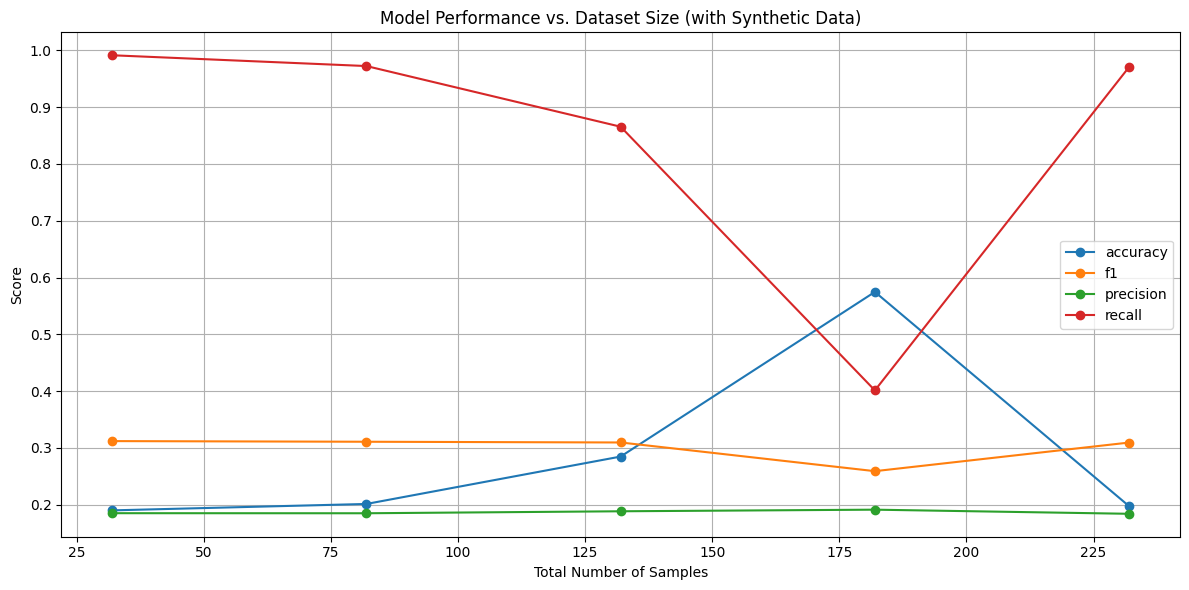

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dascim/juribert-base")


base_size = 32  # we start with 32 real samples (as per instructions)
synthetic_increment = 50  # Adding 50 synthetic samples (25 pos + 25 neg) at each step
max_synthetic = 200  # Maximum 200 synthetic samples
num_runs = 3

# Run experiments with increasing synthetic data
for synthetic_size in range(synthetic_increment, max_synthetic + 1, synthetic_increment):
    print(f"Training with {base_size} real + {synthetic_size} synthetic samples...")
    
    # Sample balanced synthetic data
    pos_synthetic = approved_cases[:synthetic_size//2]
    neg_synthetic = dismissed_cases[:synthetic_size//2]
    combined_synthetic = pos_synthetic + neg_synthetic
    
    # Convert to Dataset
    synthetic_dataset = Dataset.from_list(combined_synthetic)
    
    # Tokenize the synthetic dataset
    tokenized_synthetic = synthetic_dataset.map(tokenize_function, batched=True)
    
    # Make sure format is consistent with tokenized_real
    tokenized_synthetic.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    
    # Create a concatenated dataset by combining samples from each dataset
    # Convert back to lists to combine, then back to tensors
    combined_dataset_dict = {
        "input_ids": tokenized_real["input_ids"].tolist() + tokenized_synthetic["input_ids"].tolist(),
        "attention_mask": tokenized_real["attention_mask"].tolist() + tokenized_synthetic["attention_mask"].tolist(),
        "labels": tokenized_real["labels"].tolist() + tokenized_synthetic["labels"].tolist()
    }
    
    combined_dataset = Dataset.from_dict(combined_dataset_dict)
    combined_dataset.set_format("torch")  # Convert back to torch format
    
    # Train model with combined data
    run_metrics = []
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}")
        metrics, _ = train_model(
            combined_dataset, 
            tokenized_test, 
            f"./juribert_synthetic_{synthetic_size}_run{run+1}"
        )
        
        run_metrics.append({k.replace("eval_", ""): v for k, v in metrics.items() if k.startswith("eval_")})
    
    # Average metrics across runs
    avg_metrics = {
        k: np.mean([rm[k] for rm in run_metrics]) 
        for k in run_metrics[0].keys()
    }
    
    # Add to results
    run_results.append({
        "real_samples": base_size,
        "synthetic_samples": synthetic_size,
        "total_samples": base_size + synthetic_size,
        **avg_metrics
    })
    
    # Save all individual run results
    for i, rm in enumerate(run_metrics):
        all_results.append({
            "run": i+1,
            "real_samples": base_size,
            "synthetic_samples": synthetic_size,
            "total_samples": base_size + synthetic_size,
            **rm
        })

# Convert results to DataFrame
results_df = pl.DataFrame(run_results)
all_results_df = pl.DataFrame(all_results)

# Display results
print("\nAggregated Results:")
display(results_df)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
metrics_to_plot = ["accuracy", "f1", "precision", "recall"]
x = results_df["total_samples"].to_list()

for metric in metrics_to_plot:
    plt.plot(x, results_df[metric], marker='o', label=metric)
    
plt.xlabel("Total Number of Samples")
plt.ylabel("Score")
plt.title("Model Performance vs. Dataset Size (with Synthetic Data)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save results
results_df.write_csv("results/juribert_synthetic_results.csv")
all_results_df.write_csv("results/juribert_synthetic_results_detailed.csv")

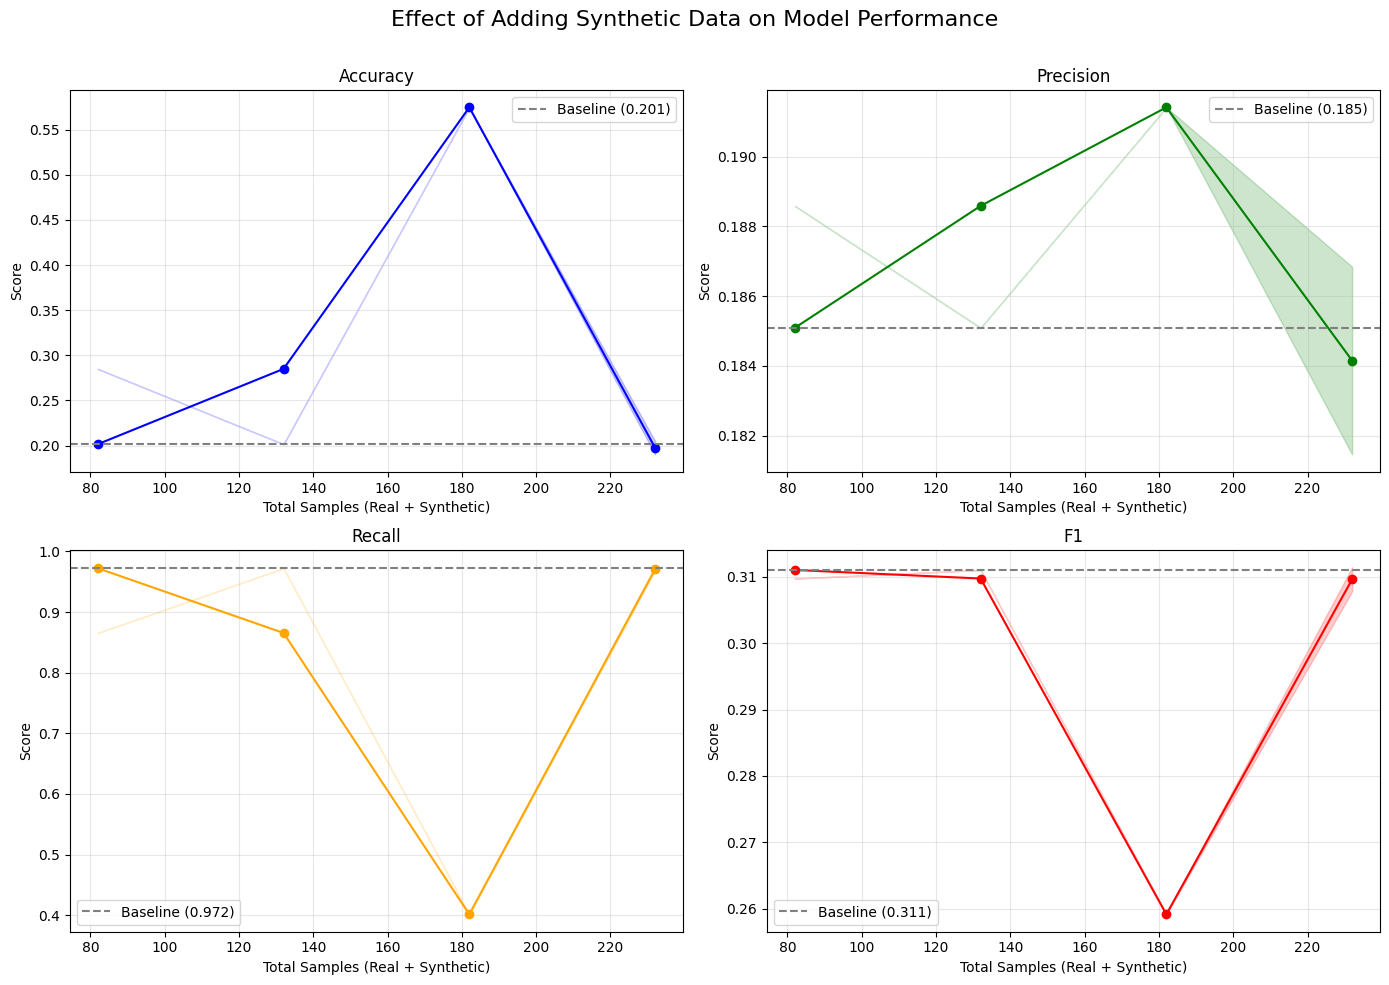

In [23]:
mean_results_pd = mean_results_pd.sort_values('total_samples')
std_results_pd = std_results_pd.sort_values('total_samples') 

# Now create the plots with properly ordered data
plt.figure(figsize=(14, 10))

# Create subplots for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1']
colors = ['blue', 'green', 'orange', 'red']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    
    # Get values from sorted DataFrames
    x = mean_results_pd['total_samples']
    y = mean_results_pd[metric]
    yerr = std_results_pd[metric]
    
    # Plot with error bands
    plt.plot(x, y, marker='o', color=colors[i])
    plt.fill_between(
        x, 
        np.maximum(0, y - yerr),
        np.minimum(1, y + yerr),
        color=colors[i], 
        alpha=0.2
    )
    
    # Add baseline reference line
    baseline_value = y.iloc[0]  # First value in sorted data
    plt.axhline(y=baseline_value, color='gray', linestyle='--', 
                label=f'Baseline ({baseline_value:.3f})')
    
    plt.title(f'{metric.capitalize()}')
    plt.xlabel('Total Samples (Real + Synthetic)')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.suptitle('Effect of Adding Synthetic Data on Model Performance', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("results/synthetic_data_performance_subplots.png", dpi=300)
plt.show()

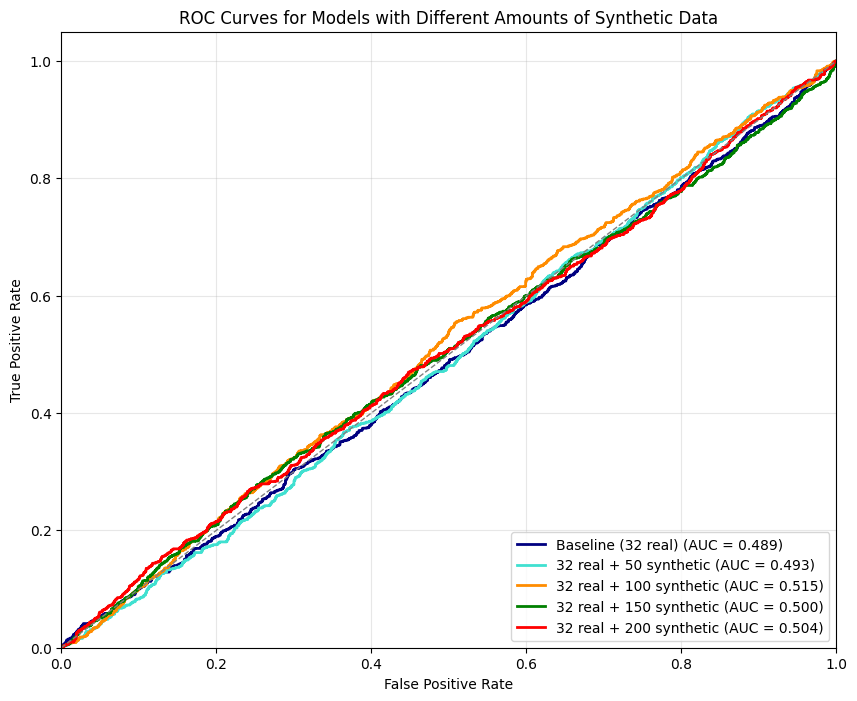

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_and_get_roc(model_path, test_dataset):
    """Load a model from path and evaluate it to get ROC curve data"""
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()
    
    # Create a PyTorch DataLoader
    from torch.utils.data import DataLoader
    dataloader = DataLoader(test_dataset, batch_size=16)
    
    all_labels = []
    all_probs = []
    
    # Run inference without gradient calculation
    with torch.no_grad():
        for batch in dataloader:
            # Move batch to GPU if available
            if torch.cuda.is_available():
                batch = {k: v.cuda() for k, v in batch.items()}
                model = model.cuda()
            
            outputs = model(**{k: v for k, v in batch.items() if k != 'labels'})
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
            
            all_labels.extend(batch['labels'].cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of positive class
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Plot ROC curves for different models
plt.figure(figsize=(10, 8))

# Define models to evaluate - one baseline and one from each synthetic data size
model_paths = [
    ("Baseline (32 real)", "./juribert_baseline/best"),
    ("32 real + 50 synthetic", "./juribert_synthetic_50_run1/best"),
    ("32 real + 100 synthetic", "./juribert_synthetic_100_run1/best"),
    ("32 real + 150 synthetic", "./juribert_synthetic_150_run1/best"),
    ("32 real + 200 synthetic", "./juribert_synthetic_200_run1/best")
]

# Colors for different curves
colors = ['navy', 'turquoise', 'darkorange', 'green', 'red']

# Evaluate each model and plot its ROC curve
for i, (name, path) in enumerate(model_paths):
    try:
        fpr, tpr, roc_auc = evaluate_and_get_roc(path, tokenized_test)
        plt.plot(
            fpr, 
            tpr, 
            lw=2, 
            color=colors[i],
            label=f'{name} (AUC = {roc_auc:.3f})'
        )
    except Exception as e:
        print(f"Error evaluating {name}: {e}")

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

# Set plot details
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Models with Different Amounts of Synthetic Data')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# Save the plot
plt.savefig("results/roc_curves_synthetic_data.png", dpi=300, bbox_inches='tight')
plt.show()

# 5. Optimal Technique Application